In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings
import statsmodels.api as sm

from sklearn.metrics import r2_score
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression , Ridge, Lasso
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)


# Read the dataset

### Important Functions

In [2]:
# Get Subplots
def plot_subplots(df, field_name, target_field, row, column, index):
    plt.subplot(row,column,index)
    sns.boxplot(x=field_name, y=target_field, data=df)

# Get statsmodel based linear model 
def get_sm_linear_model(df_X_train,y_training_data_set):
    # Add a constant 
    df_X_train_sm = sm.add_constant(df_X_train)
    linear_regression = sm.OLS(y_training_data_set,df_X_train_sm)
    linear_model = linear_regression.fit()
    return linear_model, df_X_train_sm

# Create labels for categorical data 
def create_category_labels(data_frame, field_name, dict_value_label):
    for key in dict_value_label.keys():
        data_frame.loc[data_frame[field_name] == key,field_name] = dict_value_label[key]
        
# Remove column from data_frame , field_name is a string value        
def remove_field(df, field_name):
    filtered_df = df.drop([field_name], axis=1)
    return filtered_df

# Remove columns from data_frame , field_names is a list    
def remove_fields(df, field_names):
    filtered_df = df.drop(field_names, axis=1)
    return filtered_df
  
# Get VIF     
def get_vif(df):
    vif = pd.DataFrame()    
    vif['Features'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values,i) for i in range(df.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    vif = vif.sort_values(by="VIF", ascending=False)
    return vif

def impute_missing_values(df, field_name, median_value):
    df[field_name] = df[field_name].fillna(median_value)
 
 
def createLinearRegressionModel(X_training_data,y_training_data,featureList,round_off=4):
    X_train = X_training_data[featureList]
    # Add constant
    X_train_sm = sm.add_constant(X_train)
    lr = sm.OLS(y_training_data,X_train_sm)
    lr_model = lr.fit()
    print("----------VIF Details --------------")
    vif = pd.DataFrame()
    vif["Feature"] = X_train.columns
    vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    vif["VIF"] = round(vif["VIF"], round_off)
    vif_list = vif.sort_values(by="VIF",ascending=False)
    print(vif_list.head(30))
    return lr_model.summary()       
          

### Load the Data and Some initial Analysis on data 

In [3]:
df_sur_hou = pd.read_csv("train.csv")
df_sur_hou.head() 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df_sur_hou.GarageCond.value_counts

<bound method IndexOpsMixin.value_counts of 0       TA
1       TA
2       TA
3       TA
4       TA
        ..
1455    TA
1456    TA
1457    TA
1458    TA
1459    TA
Name: GarageCond, Length: 1460, dtype: object>

In [5]:
df_sur_hou.shape

(1460, 81)

In [6]:
df_sur_hou.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
df_sur_hou.describe()
#1460 rows are there

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## Checking the dataset for nulls

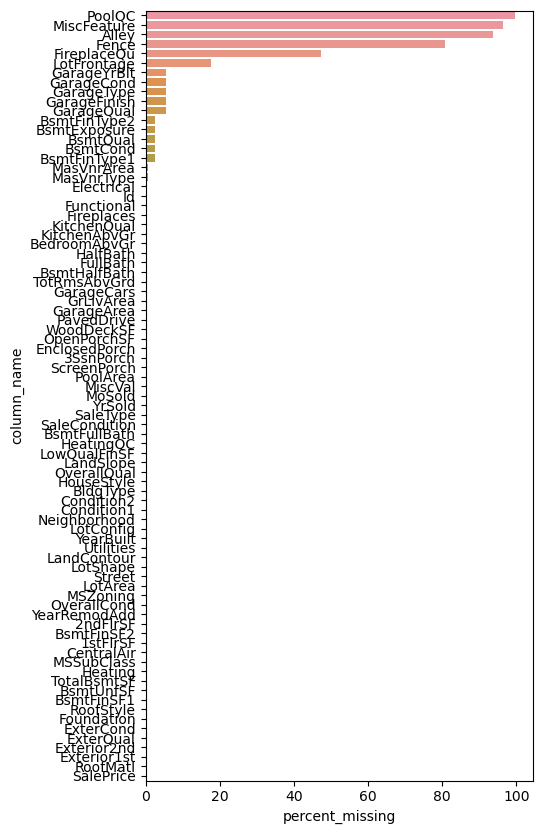

In [8]:
percent_missing = df_sur_hou.isnull().sum() * 100 / len(df_sur_hou)
missing_values_df = pd.DataFrame({'column_name': df_sur_hou.columns, 'percent_missing': percent_missing})
missing_values_df.sort_values('percent_missing', inplace=True, ascending=False)
plt.figure(figsize=(5,10))
sns.barplot(x = 'percent_missing',y = 'column_name',data = missing_values_df)
plt.show()


In [9]:
missing_values_df.sort_values(by="percent_missing",ascending=False)

,column_name,percent_missing
PoolQC,PoolQC,99.520548
MiscFeature,MiscFeature,96.301370
Alley,Alley,93.767123
Fence,Fence,80.753425
FireplaceQu,FireplaceQu,47.260274
LotFrontage,LotFrontage,17.739726
GarageYrBlt,GarageYrBlt,5.547945
GarageCond,GarageCond,5.547945
GarageFinish,GarageFinish,5.547945
GarageQual,GarageQual,5.547945


##### As we can see the threshold of missing values is 80 , we should remove columns with greater than 80% null values but lets inspect those columns which are less than 80 but more than 20



In [10]:
lst_missing_columns_80 = missing_values_df[percent_missing >= 80]['column_name'].to_list()
lst_missing_columns_80


['PoolQC', 'MiscFeature', 'Alley', 'Fence']

### FireplaceQu

In [11]:
# this is a categorical variable and generally homes have no fireplace
# we can replace this with NA as mentioned in data dictionary 
impute_missing_values(df_sur_hou,"FireplaceQu","NA")

<AxesSubplot:>

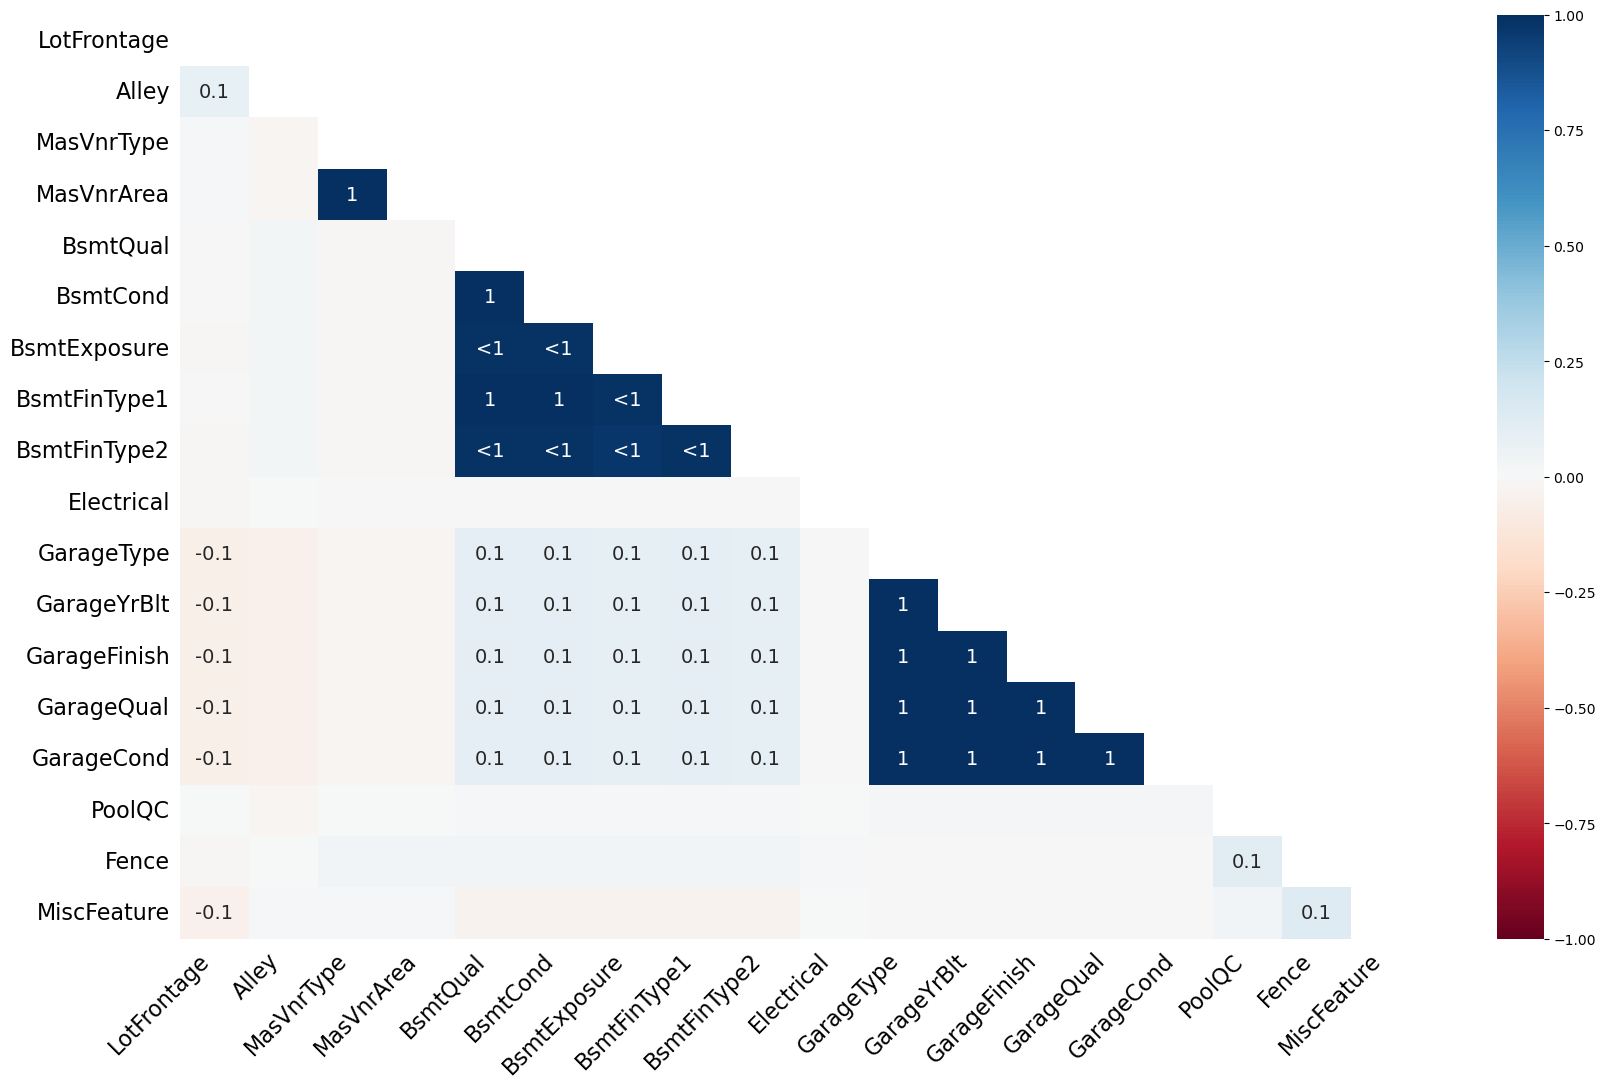

In [12]:
msno.heatmap(df_sur_hou)

In [13]:
#remove fields 5 fields removed 
df_sur_hou_2 = remove_fields(df_sur_hou,lst_missing_columns_80)
df_sur_hou_2

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,NA,Attchd,1950.0,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,0,4,2010,WD,Normal,142125


In [14]:
df_sur_hou_2.shape

(1460, 77)

<AxesSubplot:>

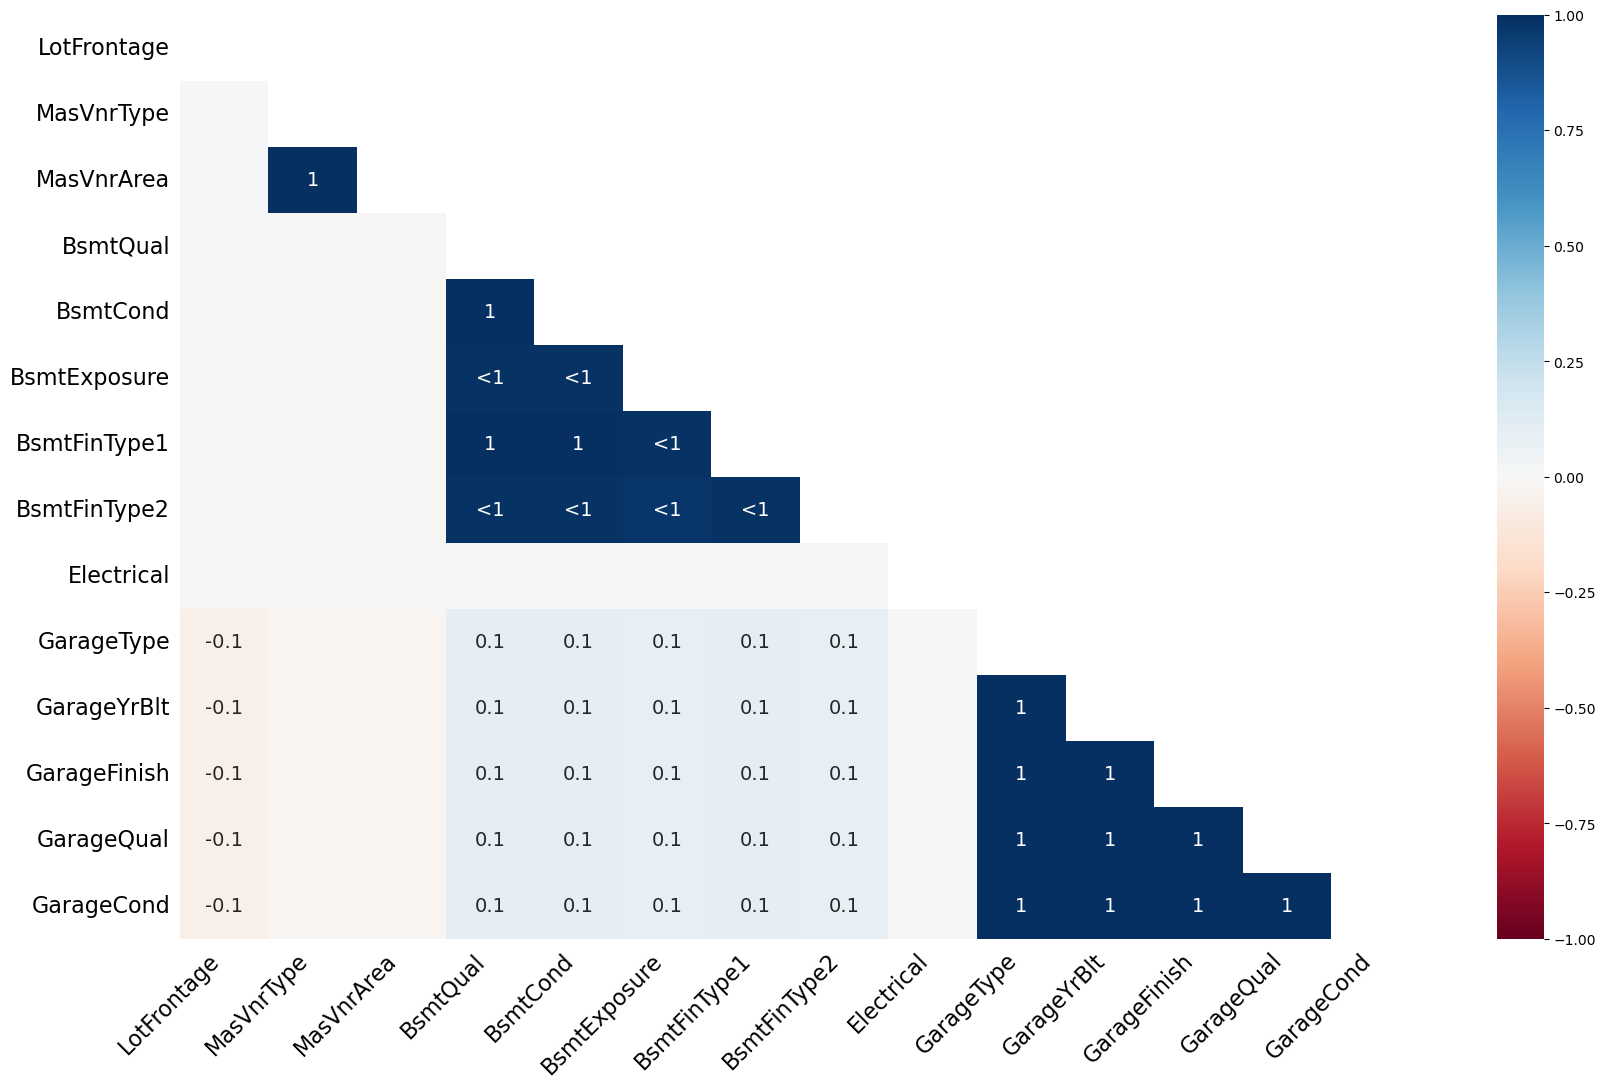

In [15]:
msno.heatmap(df_sur_hou_2)

In [16]:
# check missing values again and get list of columns to be imputed 
mis_val_impute_lst = missing_values_df[(missing_values_df['percent_missing'] > 0) & (missing_values_df['percent_missing'] < 20)]['column_name'].to_list()
mis_val_impute_lst

['LotFrontage',
 'GarageYrBlt',
 'GarageCond',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'BsmtFinType2',
 'BsmtExposure',
 'BsmtQual',
 'BsmtCond',
 'BsmtFinType1',
 'MasVnrArea',
 'MasVnrType',
 'Electrical']

### Remove id

In [17]:
#### Remove id columns
df_sur_hou_3 = remove_field(df_sur_hou_2,"Id")
df_sur_hou_3.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000


<AxesSubplot:ylabel='LotFrontage'>

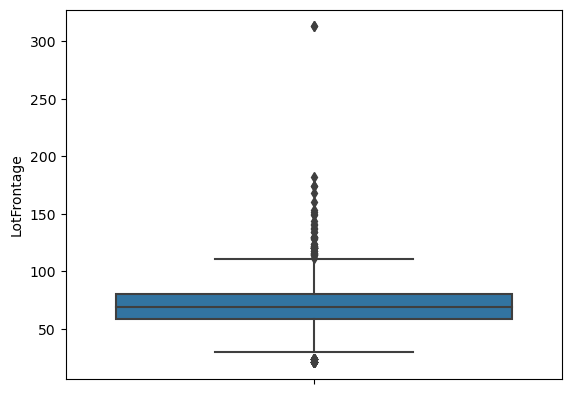

In [18]:
# Lot Frontage Column 
sns.boxplot(data=df_sur_hou_2, y="LotFrontage")

### Check for numerical and categorical columns 

In [19]:
# Check the unique values in categorical columns 
categorical_features = [feature for feature in df_sur_hou_2.columns if df_sur_hou_2[feature].dtypes == 'O']
distinct_values = []
for cols in categorical_features:
    distinct_values.append(len(df_sur_hou_3[cols].value_counts()))

col_dict={'column_name': categorical_features,'Distinct_Values': distinct_values}
pd.DataFrame(col_dict)

# sns.boxplot(data=df_sur_hou_2, y="LotFrontage")

,column_name,Distinct_Values
0,MSZoning,5
1,Street,2
2,LotShape,4
3,LandContour,4
4,Utilities,2
5,LotConfig,5
6,LandSlope,3
7,Neighborhood,25
8,Condition1,9
9,Condition2,8


### Treatment of Basement values

In [20]:
#### Basement has 5 fields in null values , as per data dictionary we can replace them with NA 
#'BsmtFinType2'
#'BsmtExposure'
#'BsmtQual'
#'BsmtCond'
#'BsmtFinType1'
for col in ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']:
    df_sur_hou_3[col].astype(str)
    df_sur_hou_3[col].fillna('NA',inplace=True)


<AxesSubplot:>

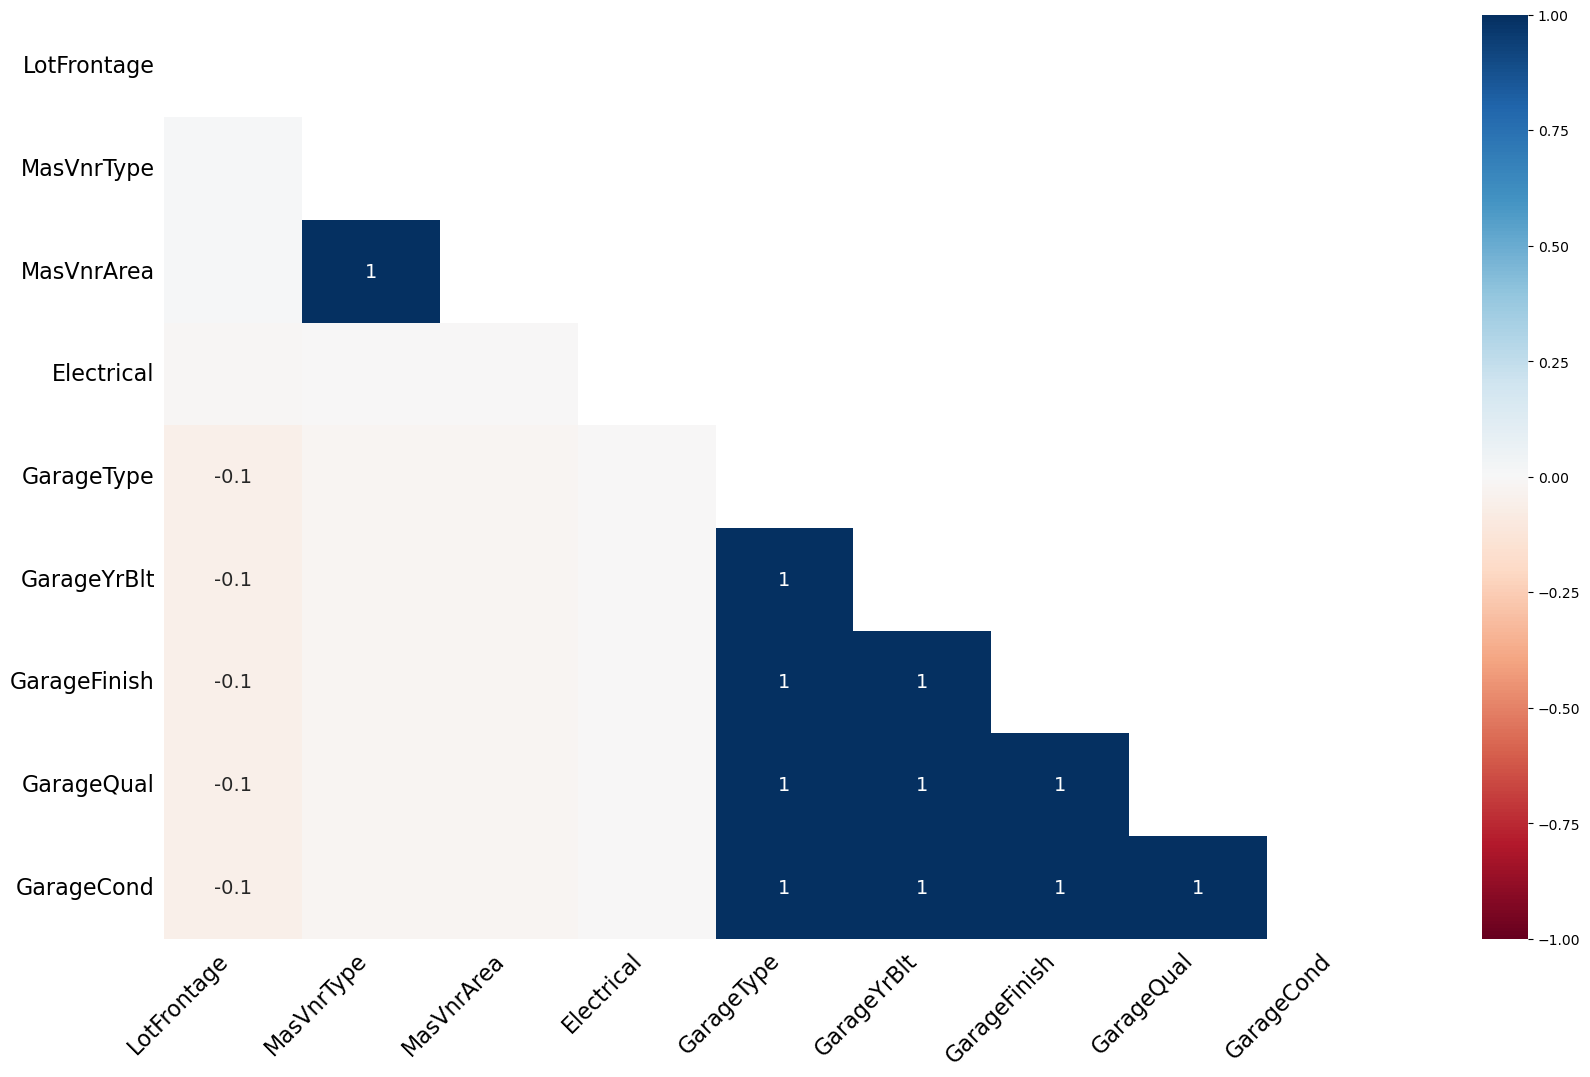

In [21]:
## check null values again 
msno.heatmap(df_sur_hou_3)

### Garage checks

In [22]:
# Now we check the Garages
# GarageYrBlt we omit for now  
for col in ['GarageType','GarageFinish','GarageQual','GarageCond']:
    df_sur_hou_3[col].astype(str)
    df_sur_hou_3[col].fillna('NA',inplace=True)
    

<AxesSubplot:>

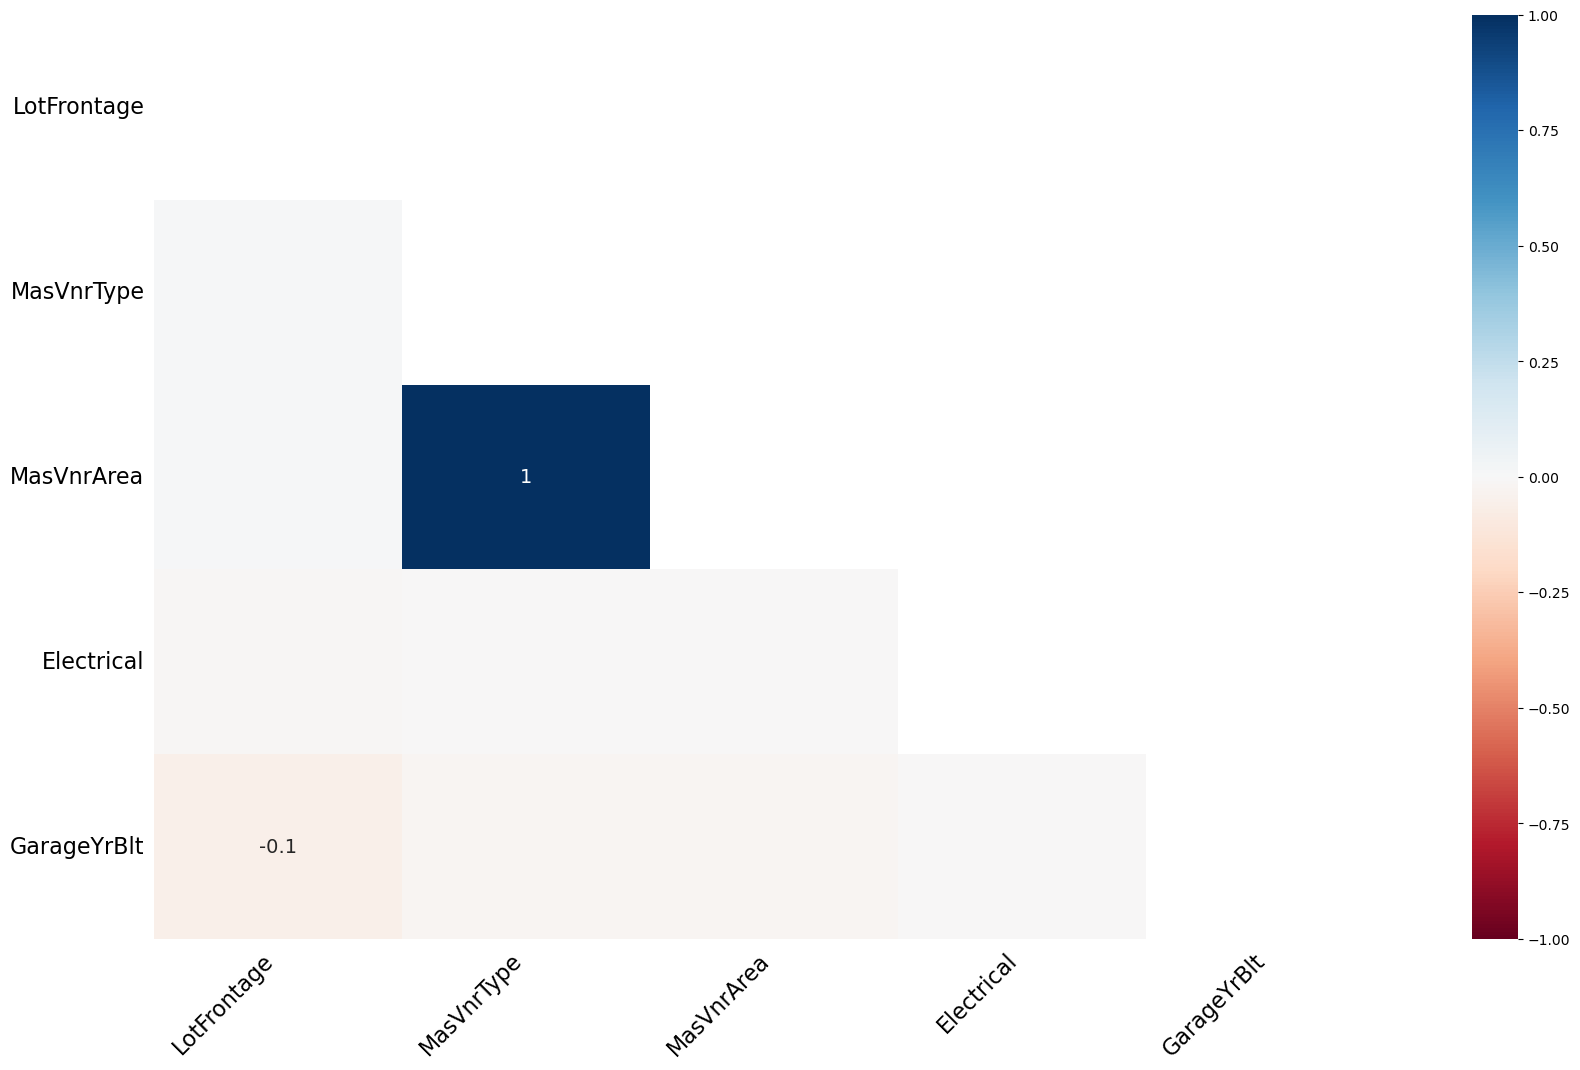

In [23]:
## check null values again 
msno.heatmap(df_sur_hou_3)

In [24]:
df_sur_hou_3.GarageCond.value_counts

<bound method IndexOpsMixin.value_counts of 0       TA
1       TA
2       TA
3       TA
4       TA
        ..
1455    TA
1456    TA
1457    TA
1458    TA
1459    TA
Name: GarageCond, Length: 1460, dtype: object>

In [25]:
df_sur_hou_3['GarageYrBlt'].value_counts
# garage Yearblt is a year field , it is date time field hence should be converted to year 
# not sure if 0 would help but its a float field with no rule in calculation 
df_sur_hou_3['GarageYrBlt'].fillna(0,inplace=True)

In [26]:
# MS Zoning 
df_sur_hou_3['Electrical'].value_counts()
# Pure Categorical variable no order in it 


SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [27]:
# replace with mode 
df_sur_hou_3['Electrical'] = df_sur_hou_3['Electrical'].fillna(df_sur_hou_3['Electrical'].mode()[0])
df_sur_hou_3['Electrical'].value_counts()

SBrkr    1335
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [28]:
#MasVNRType
df_sur_hou_3['MasVnrType'].value_counts()


None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

<AxesSubplot:>

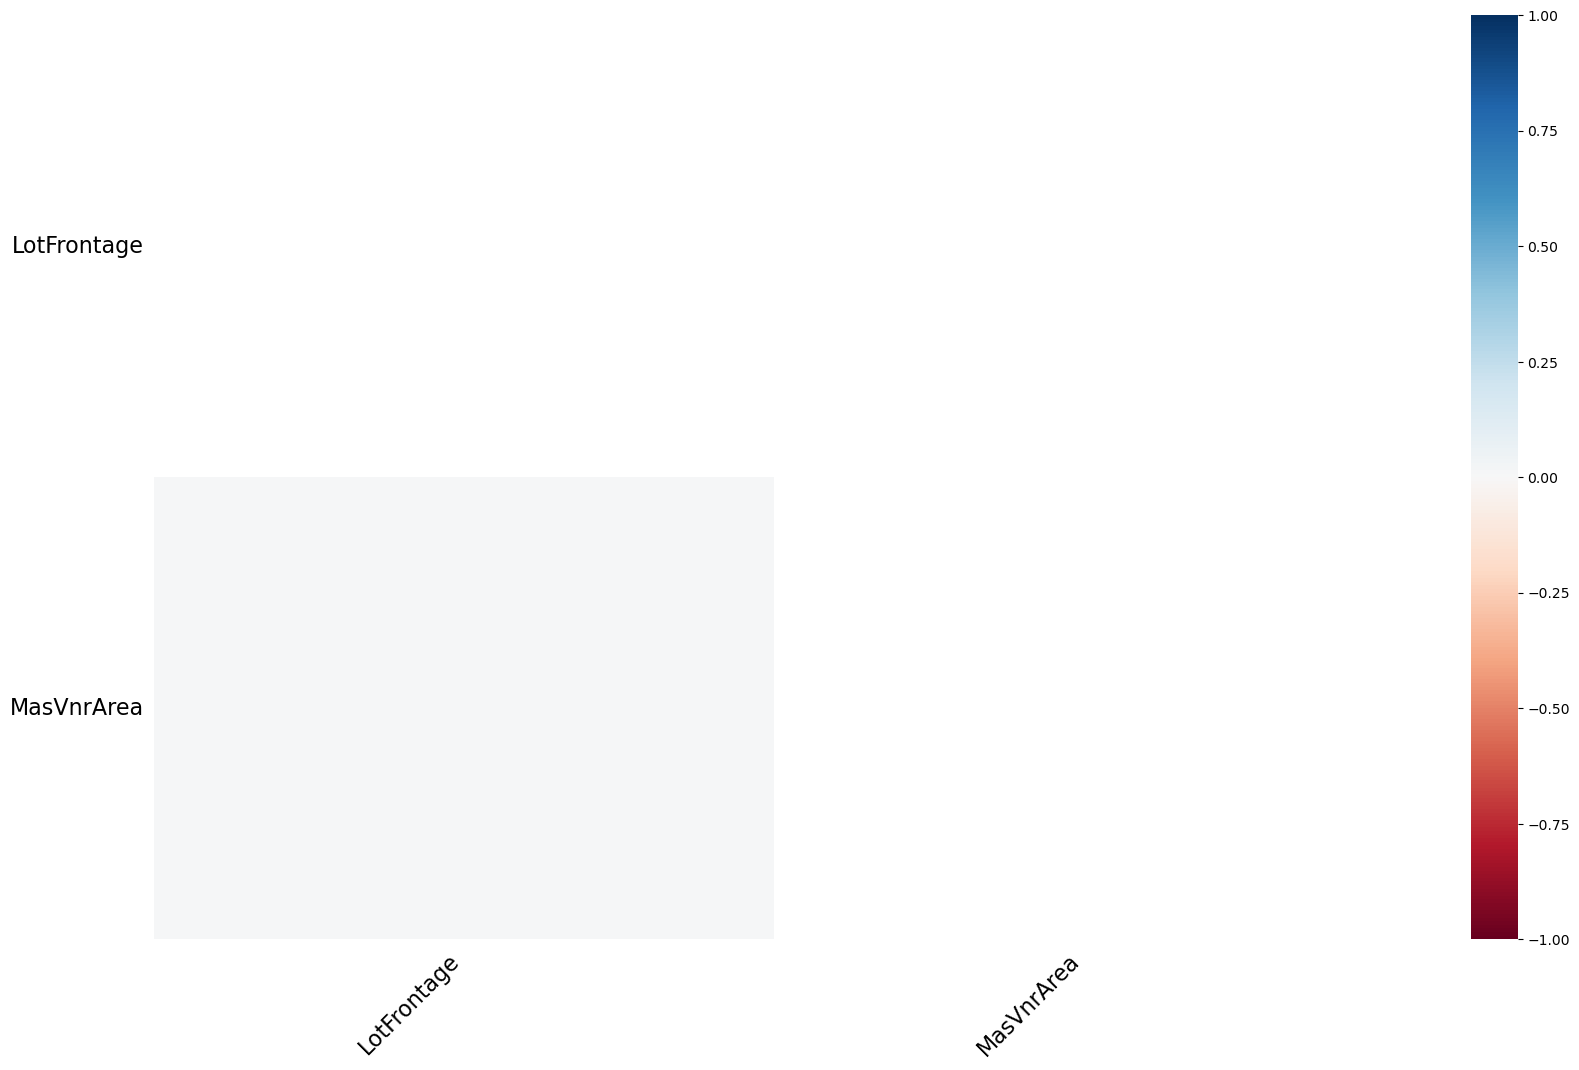

In [29]:
#Replace MasvnrTpe null values with none
df_sur_hou_3['MasVnrType'].fillna('None',inplace=True)
## check null values again 
msno.heatmap(df_sur_hou_3)

<AxesSubplot:ylabel='MasVnrArea'>

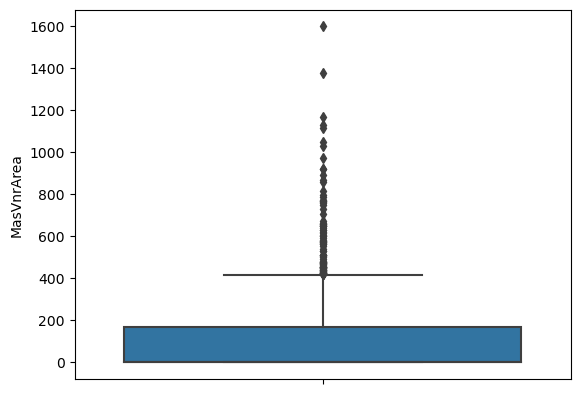

In [30]:
# Deal with MasVNrArea
sns.boxplot(df_sur_hou_3, y = "MasVnrArea")

In [31]:
#Lot of Outliers data , hence using median 
df_sur_hou_3['MasVnrArea'] = df_sur_hou_3['MasVnrArea'].fillna(df_sur_hou_3['MasVnrArea'].median()) 

In [32]:
# same with LotFrontage
df_sur_hou_3['LotFrontage'] = df_sur_hou_3['LotFrontage'].fillna(df_sur_hou_3['LotFrontage'].median()) 

In [33]:
df_sur_hou_3.isnull().sum()[df_sur_hou_3.isnull().sum()>0]

Series([], dtype: int64)

In [34]:
df_sur_hou_3.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
      

## Categorical data

In [35]:
# Now lets start with Ordinal varaiables

# if we notice the data dictionary we see that the following mappings are common to some fields
# GarageQual GarageCond FireplaceQu ExterQual ExterCond BsmtQual BsmtCond HeatingQC KitchenQual
# the fields are NA, Po, Fa, TA, Gd, Ex

ratings_dictionary =  {"NA":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5}
ratings_columns = ['GarageQual', 'GarageCond', 'FireplaceQu', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual']

for cols in ratings_columns:
    df_sur_hou_3[cols] = df_sur_hou_3[cols].astype(str)
    df_sur_hou_3[cols] = df_sur_hou_3[cols].map(ratings_dictionary)

# this has a different mapping 
bsmt_exposure_ratings_dictionary =  {"NA":0 , "No":1 , "Mn":2 ,"Av":3, "Gd":4}
df_sur_hou_3['BsmtExposure'] = df_sur_hou_3['BsmtExposure'].map(bsmt_exposure_ratings_dictionary)


In [36]:
basement_fin_type_dictionary = {"NA":0, "Unf":1, "LwQ":2, "Rec":3, "BLQ":4, "ALQ":5, "GLQ":6}
basement_fin_type_fields = ['BsmtFinType1','BsmtFinType2']

for cols in basement_fin_type_fields:
    df_sur_hou_3[cols] = df_sur_hou_3[cols].astype(str)
    df_sur_hou_3[cols] = df_sur_hou_3[cols].map(basement_fin_type_dictionary)

#### Derived fields


In [37]:
df_sur_hou_3["HouseAge"] = df_sur_hou_3.apply(lambda df_sur_hou_3:df_sur_hou_3["YrSold"]-df_sur_hou_3["YearBuilt"],axis=1)
df_sur_hou_3.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,HouseAge
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4,3,PConc,4,3,1,6,706,1,0,150,856,GasA,5,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,4,8,Typ,0,0,Attchd,2003.0,RFn,2,548,3,3,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500,5
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,CBlock,4,3,4,5,978,1,0,284,1262,GasA,5,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,3,6,Typ,1,3,Attchd,1976.0,RFn,2,460,3,3,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500,31
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4,3,PConc,4,3,2,6,486,1,0,434,920,GasA,5,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,4,6,Typ,1,3,Attchd,2001.0,RFn,2,608,3,3,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500,7
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,3,3,BrkTil,3,4,1,5,216,1,0,540,756,GasA,4,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,4,7,Typ,1,4,Detchd,1998.0,Unf,3,642,3,3,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000,91
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4,3,PConc,4,3,3,6,655,1,0,490,1145,GasA,5,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,4,9,Typ,1,3,Attchd,2000.0,RFn,3,836,3,3,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000,8


In [38]:
# drop the original fields
df_sur_hou_4 = remove_fields(df_sur_hou_3,['YrSold','YearBuilt'])
df_sur_hou_4.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,HouseAge
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4,3,PConc,4,3,1,6,706,1,0,150,856,GasA,5,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,4,8,Typ,0,0,Attchd,2003.0,RFn,2,548,3,3,Y,0,61,0,0,0,0,0,2,WD,Normal,208500,5
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,CBlock,4,3,4,5,978,1,0,284,1262,GasA,5,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,3,6,Typ,1,3,Attchd,1976.0,RFn,2,460,3,3,Y,298,0,0,0,0,0,0,5,WD,Normal,181500,31
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4,3,PConc,4,3,2,6,486,1,0,434,920,GasA,5,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,4,6,Typ,1,3,Attchd,2001.0,RFn,2,608,3,3,Y,0,42,0,0,0,0,0,9,WD,Normal,223500,7
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,3,3,BrkTil,3,4,1,5,216,1,0,540,756,GasA,4,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,4,7,Typ,1,4,Detchd,1998.0,Unf,3,642,3,3,Y,0,35,272,0,0,0,0,2,WD,Abnorml,140000,91
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4,3,PConc,4,3,3,6,655,1,0,490,1145,GasA,5,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,4,9,Typ,1,3,Attchd,2000.0,RFn,3,836,3,3,Y,192,84,0,0,0,0,0,12,WD,Normal,250000,8


### Target Variable

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

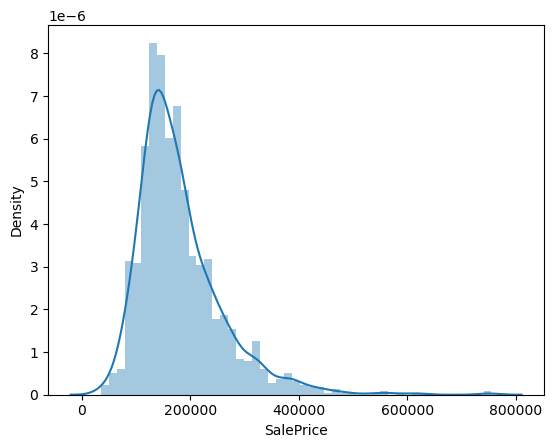

In [39]:
#### Check Ditribution of target variable
sns.distplot(df_sur_hou_4['SalePrice'])
# Skewed curve 

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

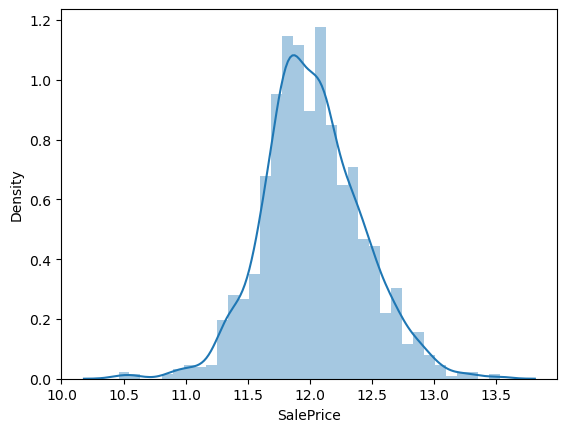

In [40]:
df_sur_hou_4['SalePrice'] = np.log(df_sur_hou_4['SalePrice'])
sns.distplot(df_sur_hou_4['SalePrice'])

### Correlation

Text(0.5, 1.0, 'Housing Fields Correlation')

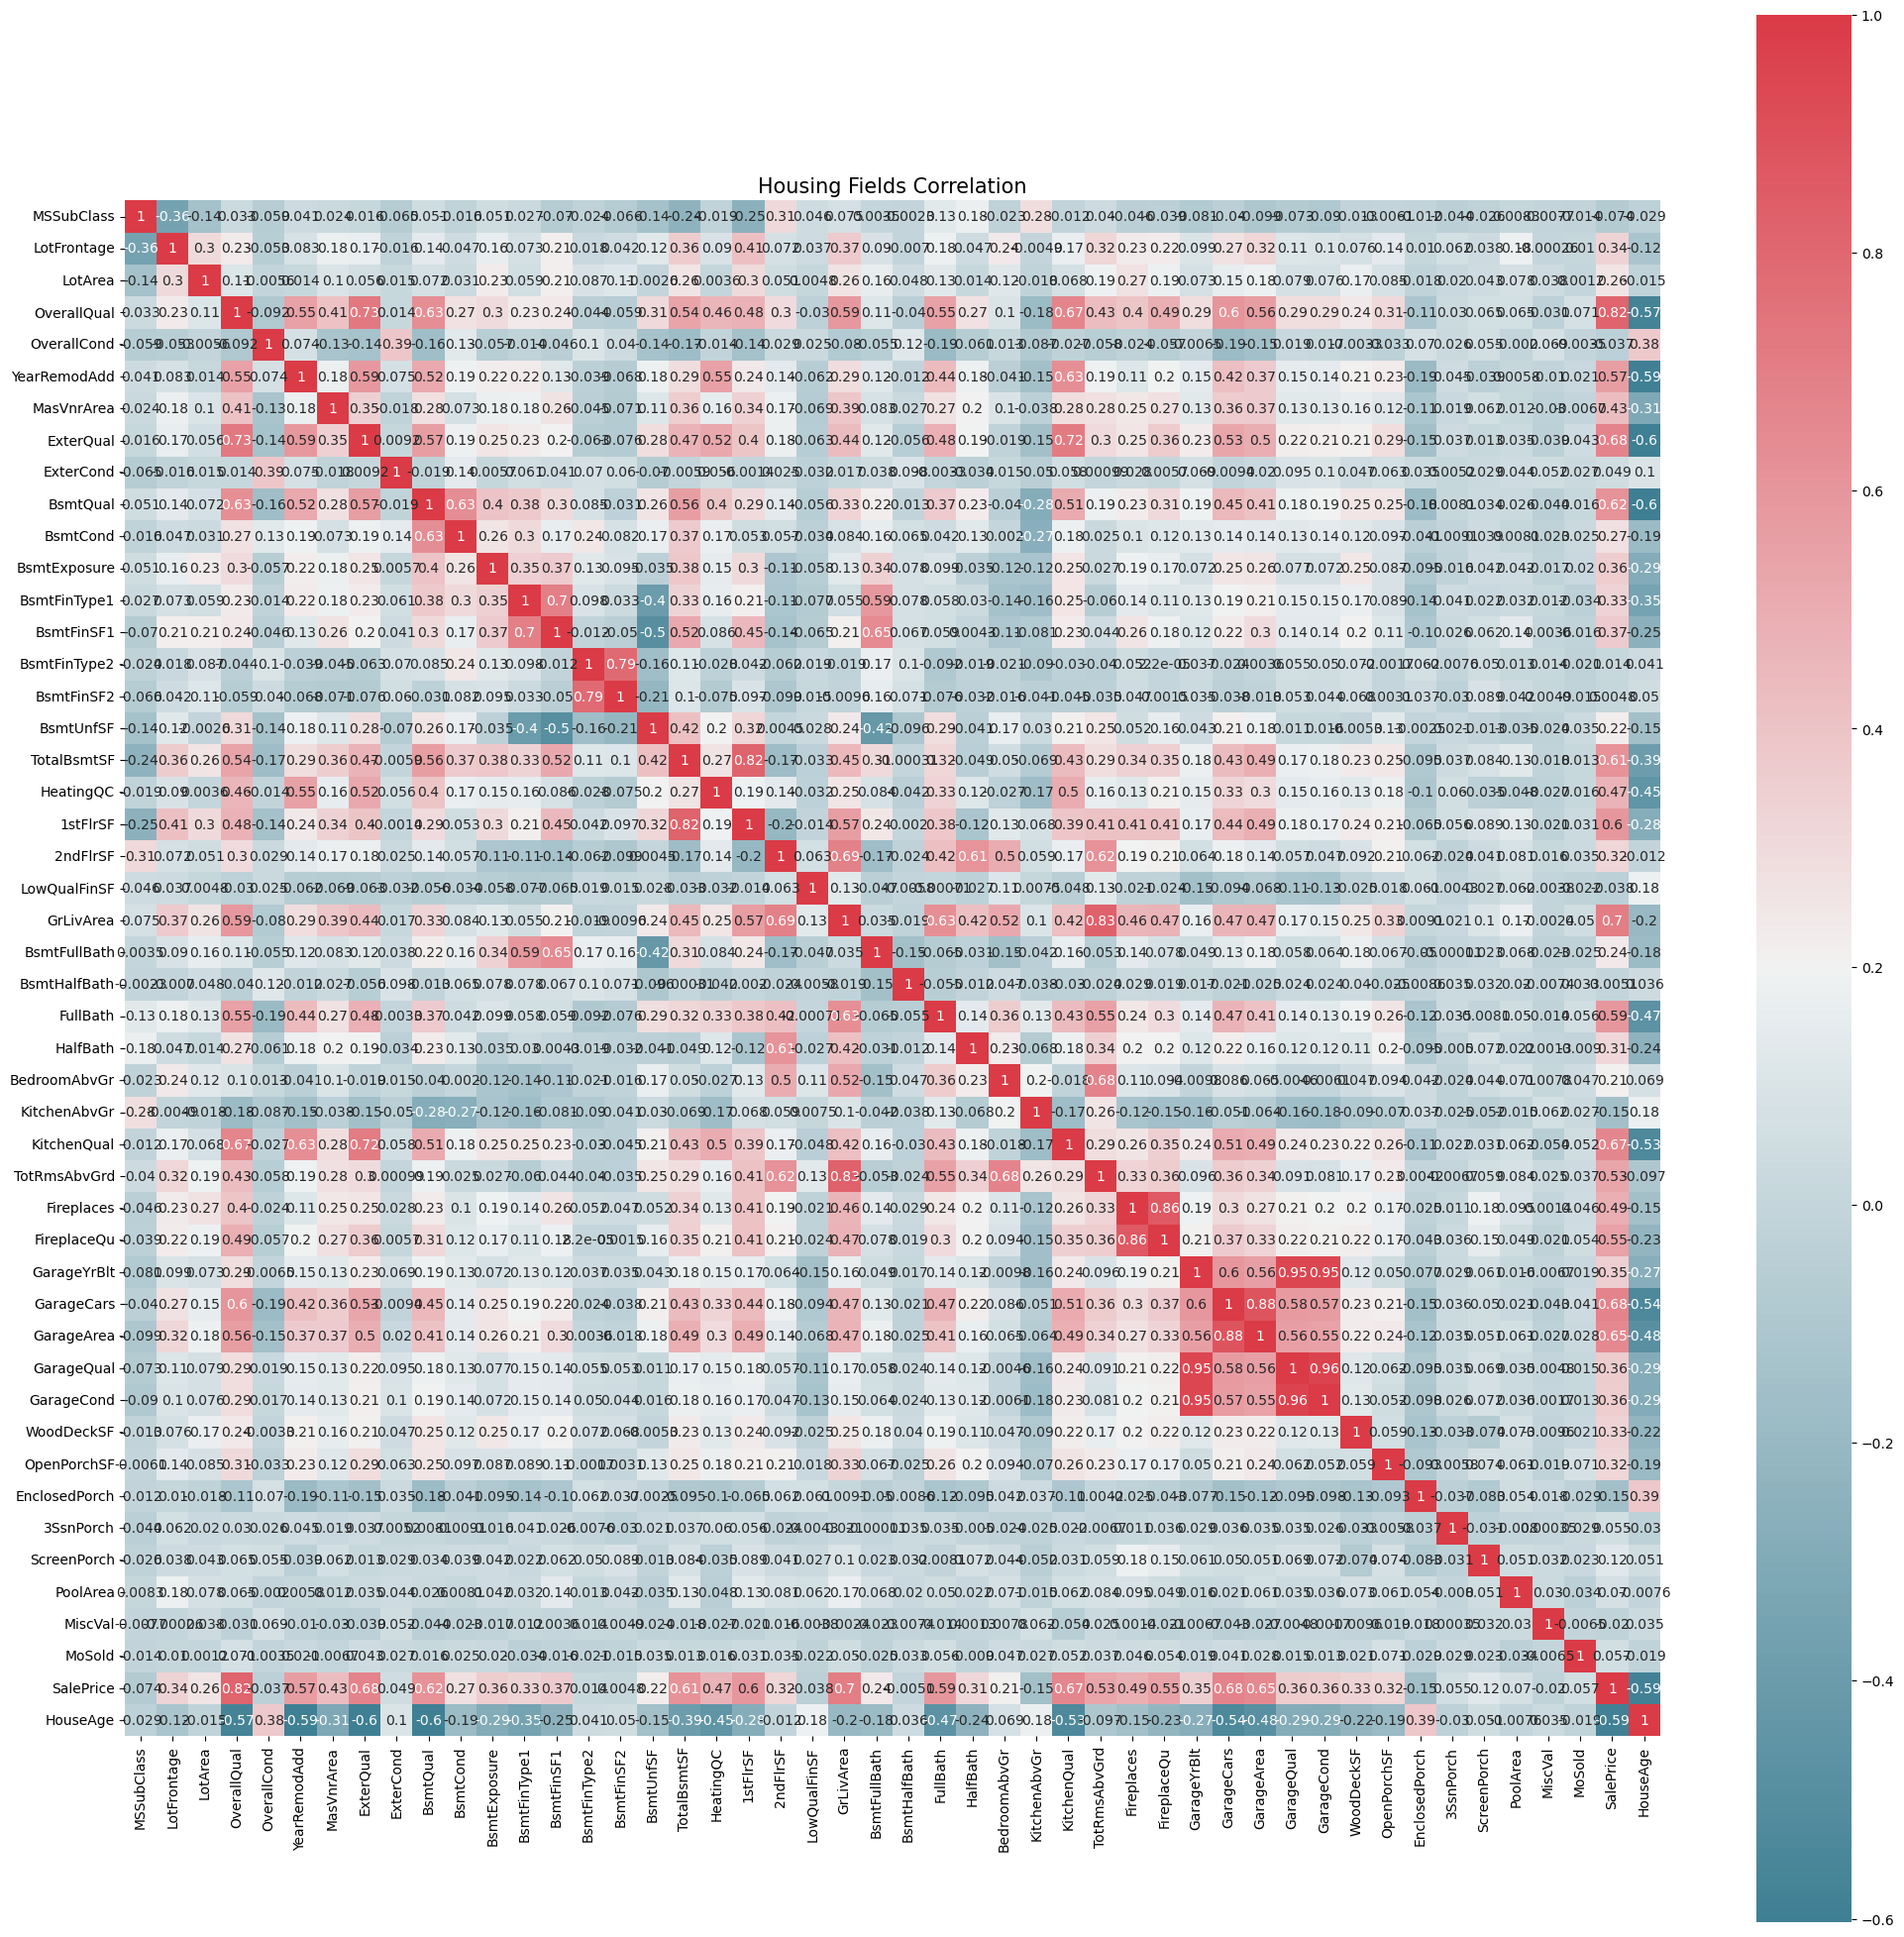

In [41]:
plt.figure(4,figsize=(25,25))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Check data types of columns
numerical_features = [feature for feature in df_sur_hou_4.columns if df_sur_hou_4[feature].dtypes != 'O']
categorical_features = [feature for feature in df_sur_hou_4.columns if df_sur_hou_4[feature].dtypes == 'O']
correlation_coefficents = df_sur_hou_4[numerical_features].corr()
sns.heatmap(correlation_coefficents,annot=True,cmap=cmap,square=True)
plt.title('Housing Fields Correlation', size=15)

## Start building the Model



In [42]:
col_names = df_sur_hou_4.columns
df_sur_hou_4.shape

(1460, 75)

In [43]:
df_sur_hou_4 = pd.get_dummies(df_sur_hou_4, columns=categorical_features, drop_first = True)
df_sur_hou_4.shape

(1460, 205)

In [44]:
df_train, df_test = train_test_split(df_sur_hou_4, train_size=0.70, test_size=0.30, random_state=100)
df_train.shape, df_test.shape

((1021, 205), (438, 205))

In [45]:
# create training set
y_train = df_train.pop("SalePrice")
X_train = df_train

y_train.shape, X_train.shape

((1021,), (1021, 204))

In [46]:
#create test set 
y_test = df_test.pop("SalePrice")
X_test = df_test

y_test.shape, X_test.shape

((438,), (438, 204))

In [47]:
# Scale the numeric features
scaling_features = numerical_features.copy()
scaling_features.remove("SalePrice")
scaler = StandardScaler()
X_train[scaling_features] = scaler.fit_transform(X_train[scaling_features])
X_test[scaling_features] = scaler.transform(X_test[scaling_features])

In [48]:
# Create copies of datasets
X_train_clone = X_train.copy()
X_test_clone = X_test.copy()
y_train_clone = y_train.copy()
y_test_clone = y_test.copy()

X_train_clone2 = X_train.copy()
X_test_clone2 = X_test.copy()
y_train_clone2 = y_train.copy()
y_test_clone2 = y_test.copy()

X_train_clone3 = X_train.copy()
X_test_clone3 = X_test.copy()
y_train_clone3 = y_train.copy()
y_test_clone3 = y_test.copy()

X_train_clone4 = X_train.copy()
X_test_clone4 = X_test.copy()
y_train_clone4 = y_train.copy()
y_test_clone4 = y_test.copy()

X_train_clone5 = X_train.copy()
X_test_clone5 = X_test.copy()
y_train_clone5 = y_train.copy()
y_test_clone5 = y_test.copy()


In [49]:
summary=createLinearRegressionModel(X_train_clone,y_train_clone,X_train.columns)
#['constant', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'ExterQual', 'ExterCond', 
# 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFinSF2', 'HeatingQC', '1stFlrSF', 'GrLivArea', 'BsmtFullBath', 
# 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'FireplaceQu', 'GarageYrBlt', 
# 'GarageCars', 'GarageArea', 'GarageQual', 'WoodDeckSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 
# 'HouseAge', 'MSZoning_FV', 'MSZoning_RL', 'LandContour_Low', 'LandContour_Lvl', 'LotConfig_CulDSac', 'Neighborhood_BrkSide', 
# 'Neighborhood_ClearCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_IDOTRR', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 
# 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Condition1_Norm', 'Condition2_PosN', 'BldgType_Twnhs', 'HouseStyle_1Story', 
# 'HouseStyle_2Story', 'RoofStyle_Gable', 'Exterior1st_BrkFace', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng', 'Exterior2nd_MetalSd', 
# 'Exterior2nd_Wd Shng', 'MasVnrType_BrkFace', 'Foundation_PConc', 'CentralAir_Y', 'Functional_Typ', 'GarageType_Attchd', 'GarageFinish_RFn', 
# 'GarageFinish_Unf', 'SaleType_New', 'SaleCondition_Normal', 'SaleCondition_Partial']
summary    


----------VIF Details --------------
                   Feature        VIF
203  SaleCondition_Partial        inf
13              BsmtFinSF1        inf
127    Exterior1st_AsphShn        inf
130     Exterior1st_CBlock        inf
141    Exterior2nd_AsphShn        inf
144     Exterior2nd_CBlock        inf
22               GrLivArea        inf
20                2ndFlrSF        inf
19                1stFlrSF        inf
17             TotalBsmtSF        inf
16               BsmtUnfSF        inf
15              BsmtFinSF2        inf
21            LowQualFinSF        inf
186        GarageFinish_NA        inf
185          GarageType_NA        inf
196           SaleType_New        inf
33             GarageYrBlt  2264.2810
120       RoofMatl_CompShg  1695.5776
164           Heating_GasA  1021.5119
98         Condition2_Norm   729.5099
115        RoofStyle_Gable   558.9942
51             Street_Pave   429.9220
180      GarageType_Attchd   284.6827
49             MSZoning_RL   213.1190
138    Exteri

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     88.12
Date:                Wed, 01 Feb 2023   Prob (F-statistic):               0.00
Time:                        18:48:33   Log-Likelihood:                 1072.9
No. Observations:                1021   AIC:                            -1752.
Df Residuals:                     824   BIC:                            -780.9
Df Model:                         196                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     8.1264      0.260     31.256      0.000       7.616       8.637
MSSubClass               -0.0213      0.018     -1.164      0.245      -0.057       0.015
LotFrontage               0.0095      0.005      1.899      0.058      -0.000       0.019
LotArea                   0.0279      0.005      5.251      0.000       0.017       0.038
OverallQual               0.0589      0.007      8.247      0.000       0.045       0.073
OverallCond               0.0405      0.005      8.342      0.000       0.031       0.050
YearRemodAdd              0.0190      0.006      3.337      0.001       0.008       0.030
MasVnrArea                0.0013      0.005      0.257      0.798      -0.009       0.011
ExterQual                -0.0020      0.006     -0.338      0.735      -0.014       0.010
ExterCond                -0.0048      0.004     -1.296      0.195      -0.012       0.002
BsmtQual                  0.0050      0.008      0.663      0.508      -0.010       0.020
BsmtCond                 -0.0075      0.006     -1.249      0.212      -0.019       0.004
BsmtExposure              0.0152      0.005      3.305      0.001       0.006       0.024
BsmtFinType1              0.0080      0.005      1.506      0.133      -0.002       0.019
BsmtFinSF1                0.0340      0.005      6.920      0.000       0.024       0.044
BsmtFinType2             -0.0040      0.006     -0.690      0.491      -0.015       0.007
BsmtFinSF2                0.0064      0.005      1.169      0.243      -0.004       0.017
BsmtUnfSF                 0.0047      0.004      1.133      0.258      -0.003       0.013
TotalBsmtSF               0.0414      0.007      6.335      0.000       0.029       0.054
HeatingQC                 0.0076      0.005      1.621      0.105      -0.002       0.017
1stFlrSF                  0.0515      0.008      6.697      0.000       0.036       0.067
2ndFlrSF                  0.0468      0.008      5.561      0.000       0.030       0.063
LowQualFinSF             -0.0022      0.004     -0.537      0.592      -0.010       0.006
GrLivArea                 0.0766      0.006     12.347      0.000       0.064       0.089
BsmtFullBath              0.0150      0.005      3.017      0.003       0.005       0.025
BsmtHalfBath              0.0016      0.004      0.435      0.664      -0.006       0.009
FullBath                  0.0038      0.006      0.629      0.529      -0.008       0.016
HalfBath                  0.0052      0.005      0.962      0.336      -0.005       0.016
BedroomAbvGr              0.0019      0.006      0.341      0.733      -0.009       0.013
KitchenAbvGr             -0.0110      0.007     -1.578      0.115      -0.025       0.003
KitchenQual               0.0068      0.005      1.244      0.214      -0.004       0.017
TotRmsAbvGrd           

Ridge

In [50]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 120, 140, 160, 180, 200, 500, 1000 ]}

ridge = Ridge()
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scoring = scoring = ["r2","neg_mean_absolute_error"]
model_ridge = GridSearchCV(estimator=ridge, param_grid=params,scoring=scoring,
                          cv=folds,return_train_score=True,verbose=1,refit="r2")
model_ridge.fit(X_train,y_train)
cv_results = pd.DataFrame(model_ridge.cv_results_)
cv_results.head()

Fitting 5 folds for each of 33 candidates, totalling 165 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,split3_train_neg_mean_absolute_error,split4_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error
0,0.005610,0.000832,0.003073,0.000458,0.0001,{'alpha': 0.0001},0.647602,0.820094,0.623138,0.380843,0.871105,0.668556,0.172783,33,0.959260,0.957236,0.956190,0.959062,0.958485,0.958046,0.001166,-0.105686,-0.083176,-0.102407,-0.120989,-0.087696,-0.099991,0.013514,32,-0.056145,-0.060715,-0.059744,-0.057828,-0.059776,-0.058842,0.001643
1,0.005179,0.000773,0.003056,0.000424,0.001,{'alpha': 0.001},0.647860,0.820960,0.633870,0.395349,0.872213,0.674050,0.167825,32,0.959260,0.957226,0.956181,0.959057,0.958472,0.958039,0.001168,-0.105661,-0.083225,-0.102105,-0.120735,-0.087351,-0.099815,0.013473,31,-0.056152,-0.060752,-0.059794,-0.057866,-0.059839,-0.058881,0.001657
2,0.005561,0.001320,0.002649,0.000304,0.01,{'alpha': 0.01},0.650314,0.826854,0.714053,0.509312,0.878767,0.715860,0.131011,31,0.959247,0.956577,0.955577,0.958675,0.957673,0.957550,0.001342,-0.105426,-0.083937,-0.099855,-0.118677,-0.085782,-0.098736,0.012888,29,-0.056238,-0.061445,-0.060423,-0.058390,-0.060761,-0.059451,0.001902
3,0.005376,0.000816,0.002694,0.000408,0.05,{'alpha': 0.05},0.659256,0.832998,0.840210,0.715936,0.882327,0.786145,0.084142,30,0.959047,0.951935,0.950708,0.955248,0.952513,0.953890,0.002976,-0.104591,-0.088267,-0.096594,-0.114950,-0.086566,-0.098193,0.010564,28,-0.056721,-0.064605,-0.063591,-0.061027,-0.064530,-0.062095,0.002983
4,0.004943,0.000374,0.003252,0.000475,0.1,{'alpha': 0.1},0.667733,0.833246,0.879416,0.788853,0.882005,0.810250,0.079032,29,0.958648,0.948172,0.946234,0.951828,0.948542,0.950685,0.004369,-0.103832,-0.090505,-0.095415,-0.113100,-0.087786,-0.098128,0.009264,27,-0.057278,-0.066885,-0.066171,-0.063194,-0.066747,-0.064055,0.003644


In [51]:
ridge_score = model_ridge.best_score_
ridge_alpha = model_ridge.best_params_['alpha']
print("Ridge: Score:{0} Alpha:{1}".format(ridge_score,ridge_alpha))

Ridge: Score:0.8574829574141898 Alpha:20


In [52]:
ridge = Ridge(alpha=ridge_alpha)
ridge.fit(X_train, y_train)

Ridge(alpha=20)

In [53]:
# Model Coef and intercept
model_params = list(ridge.coef_)
model_params.insert(0,ridge.intercept_)
model_params = [round (item, 4) for  item in model_params]

cols = X_train.columns
cols = cols.insert(0, "constant")
ridge_coef = pd.DataFrame(model_params,cols)
ridge_coef.reset_index(inplace=True)
ridge_coef.columns = ["Fields","Coeff"]
ridge_coef.sort_values(by="Coeff",inplace=True,ascending=False)
ridge_coef

,Fields,Coeff
0,constant,11.7157
71,Neighborhood_Crawfor,0.0816
4,OverallQual,0.0811
81,Neighborhood_NridgHt,0.0646
23,GrLivArea,0.0605
91,Condition1_Norm,0.0528
86,Neighborhood_Somerst,0.0528
50,MSZoning_RL,0.0454
130,Exterior1st_BrkFace,0.0444
69,Neighborhood_ClearCr,0.0433


In [54]:
y_train_ridge_predicted_values = ridge.predict(X_train)
y_test_ridge_predicted_values = ridge.predict(X_test)
r2_train_ridge = round(metrics.r2_score(y_true=y_train, y_pred=y_train_ridge_predicted_values),4)
r2_test_ridge = round(metrics.r2_score(y_true=y_test, y_pred=y_test_ridge_predicted_values),4)
print("Ridge Regression r2_train:{0} , r2_test{1}".format(r2_train_ridge,r2_test_ridge))

Ridge Regression r2_train:0.9119 , r2_test0.8888


#### Lasso

In [55]:
params = {'alpha': [0.00001, 0.00005, 0.0001,0.0002, 0.0005,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008]}
lasso = Lasso()
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scoring = ["r2","neg_mean_absolute_error"]
model_lasso = GridSearchCV(cv=folds,estimator=lasso, refit="r2",param_grid=params,scoring=scoring,return_train_score=True,verbose=1)
model_lasso.fit(X_train_clone2,y_train_clone2)


Fitting 5 folds for each of 13 candidates, totalling 65 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=Lasso(),
             param_grid={'alpha': [1e-05, 5e-05, 0.0001, 0.0002, 0.0005, 0.001,
                                   0.002, 0.003, 0.004, 0.005, 0.006, 0.007,
                                   0.008]},
             refit='r2', return_train_score=True,
             scoring=['r2', 'neg_mean_absolute_error'], verbose=1)

In [56]:
lasso_results = pd.DataFrame(model_lasso.cv_results_)
lasso_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,split3_train_neg_mean_absolute_error,split4_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error
0,0.089275,0.007562,0.003352,0.000659,0.00001,{'alpha': 1e-05},0.656595,0.815846,0.656849,0.430343,0.877840,0.687495,0.155387,13,0.959121,0.957057,0.956021,0.958917,0.958320,0.957887,0.001178,-0.104677,-0.082429,-0.100665,-0.119375,-0.083987,-0.098227,0.013763,11,-0.056605,-0.061108,-0.060131,-0.058222,-0.060072,-0.059228,0.001610
1,0.047065,0.018130,0.003573,0.000426,0.00005,{'alpha': 5e-05},0.672790,0.824155,0.766957,0.602134,0.888974,0.751002,0.102880,12,0.958007,0.954248,0.953754,0.957046,0.955631,0.955737,0.001614,-0.103160,-0.083815,-0.094883,-0.113306,-0.081086,-0.095250,0.012001,6,-0.058346,-0.063580,-0.061982,-0.060415,-0.062437,-0.061352,0.001814
2,0.040218,0.022289,0.002807,0.000348,0.0001,{'alpha': 0.0001},0.685125,0.833615,0.856879,0.752190,0.894314,0.804424,0.075689,11,0.956427,0.947566,0.948007,0.952265,0.948515,0.950556,0.003376,-0.101161,-0.086960,-0.090052,-0.107144,-0.082604,-0.093584,0.009145,4,-0.059845,-0.067587,-0.065294,-0.063929,-0.067017,-0.064734,0.002765
3,0.077750,0.011995,0.003559,0.000681,0.0002,{'alpha': 0.0002},0.697212,0.839344,0.924987,0.878259,0.894269,0.846814,0.079735,6,0.952771,0.933531,0.928783,0.937573,0.934378,0.937407,0.008181,-0.098817,-0.091318,-0.086371,-0.098841,-0.086814,-0.092432,0.005502,2,-0.062294,-0.074097,-0.074062,-0.071111,-0.073394,-0.070991,0.004483
4,0.030494,0.004399,0.003285,0.000301,0.0005,{'alpha': 0.0005},0.720534,0.842412,0.922882,0.879684,0.905116,0.854126,0.072062,2,0.943574,0.922138,0.914718,0.925139,0.920396,0.925193,0.009797,-0.096216,-0.091347,-0.089448,-0.096675,-0.085436,-0.091825,0.004231,1,-0.067394,-0.077879,-0.078537,-0.076318,-0.078856,-0.075797,0.004291


In [57]:
lasso_score = model_lasso.best_score_
lasso_alpha = model_lasso.best_params_['alpha']
print("Lasso: Score:{0} Alpha:{1}".format(lasso_score,lasso_alpha))

Lasso: Score:0.8549759564074177 Alpha:0.001


In [58]:
# Model building using optimal alpha
lasso = Lasso(alpha=lasso_alpha)
lasso.fit(X_train_clone2, y_train_clone2)

Lasso(alpha=0.001)

In [59]:
# Model Coef and intercept
model_params_lasso = list(lasso.coef_)
model_params_lasso.insert(0,lasso.intercept_)
model_params_lasso = [round (item, 4) for  item in model_params_lasso]

cols = X_train.columns
cols = cols.insert(0, "constant")
lasso_coef = pd.DataFrame(model_params_lasso,cols)
lasso_coef.reset_index(inplace=True)
lasso_coef.columns = ["Fields","Coeff"]
lasso_coef.sort_values(by="Coeff",inplace=True,ascending=False)
lasso_coef


,Fields,Coeff
0,constant,11.8171
23,GrLivArea,0.1111
71,Neighborhood_Crawfor,0.1080
86,Neighborhood_Somerst,0.0987
4,OverallQual,0.0851
81,Neighborhood_NridgHt,0.0843
130,Exterior1st_BrkFace,0.0573
91,Condition1_Norm,0.0565
69,Neighborhood_ClearCr,0.0561
50,MSZoning_RL,0.0538


In [60]:
non_zero_columns = list(lasso_coef[lasso_coef["Coeff"]!=0]["Fields"].values)
# Remove constant
non_zero_columns.remove("constant")
print(non_zero_columns)

['GrLivArea', 'Neighborhood_Crawfor', 'Neighborhood_Somerst', 'OverallQual', 'Neighborhood_NridgHt', 'Exterior1st_BrkFace', 'Condition1_Norm', 'Neighborhood_ClearCr', 'MSZoning_RL', 'Neighborhood_NoRidge', 'GarageCars', 'OverallCond', 'SaleCondition_Normal', 'CentralAir_Y', 'BsmtFullBath', 'FireplaceQu', 'SaleType_New', 'LotConfig_CulDSac', 'Functional_Typ', 'GarageType_Attchd', 'BsmtFinType1', 'BsmtExposure', 'Neighborhood_StoneBr', 'Exterior2nd_MetalSd', 'SaleCondition_Partial', 'LotArea', 'FullBath', 'Exterior1st_VinylSd', 'YearRemodAdd', 'KitchenQual', 'BsmtQual', 'Foundation_PConc', 'BedroomAbvGr', 'Neighborhood_BrkSide', 'GarageQual', '1stFlrSF', 'HalfBath', 'WoodDeckSF', 'TotRmsAbvGrd', 'ScreenPorch', 'HeatingQC', 'HouseStyle_1Story', '3SsnPorch', 'EnclosedPorch', 'MSZoning_FV', 'LandContour_Lvl', 'LandContour_Low', 'GarageArea', 'MasVnrType_BrkFace', 'BsmtHalfBath', 'ExterQual', 'BsmtFinSF2', 'MoSold', 'Exterior1st_Wd Sdng', 'MiscVal', 'BsmtFinType2', 'GarageFinish_RFn', 'Exter

In [61]:
y_train_lasso_predicted_values = lasso.predict(X_train_clone2)
y_test_lasso_predicted_values = lasso.predict(X_test_clone2)
r2_train_lasso = round(metrics.r2_score(y_true=y_train, y_pred=y_train_lasso_predicted_values),4)
r2_test_lasso = round(metrics.r2_score(y_true=y_test, y_pred=y_test_lasso_predicted_values),4)
print("Lasso Regression r2_train:{0} , r2_test{1}".format(r2_train_lasso,r2_test_lasso))

Lasso Regression r2_train:0.9059 , r2_test0.887


In [62]:
# Retry with non zero columns 
summary = createLinearRegressionModel(X_train_clone,y_train_clone,non_zero_columns)
summary

----------VIF Details --------------
                  Feature      VIF
24  SaleCondition_Partial      inf
16           SaleType_New      inf
13           CentralAir_Y  17.8487
18         Functional_Typ  16.8505
0               GrLivArea  13.5090
62            GarageYrBlt  13.3102
45        LandContour_Lvl  13.1376
34             GarageQual  12.4262
8             MSZoning_RL  10.7668
12   SaleCondition_Normal   9.4843
35               1stFlrSF   8.4815
41      HouseStyle_1Story   7.8987
6         Condition1_Norm   7.5222
10             GarageCars   6.8087
47             GarageArea   6.4789
67               HouseAge   6.0641
59        RoofStyle_Gable   5.9350
38           TotRmsAbvGrd   5.5834
63      HouseStyle_2Story   5.3122
31       Foundation_PConc   5.2071
64       GarageFinish_Unf   5.0951
44            MSZoning_FV   4.9543
2    Neighborhood_Somerst   4.8701
19      GarageType_Attchd   4.6256
3             OverallQual   4.3178
27    Exterior1st_VinylSd   3.4007
50              Ex

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     149.1
Date:                Wed, 01 Feb 2023   Prob (F-statistic):               0.00
Time:                        18:48:39   Log-Likelihood:                 771.02
No. Observations:                1021   AIC:                            -1398.
Df Residuals:                     949   BIC:                            -1043.
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    11.7194      0.038    310.477      0.000      11.645      11.793
GrLivArea                 0.1349      0.014      9.859      0.000       0.108       0.162
Neighborhood_Crawfor      0.1582      0.024      6.693      0.000       0.112       0.205
Neighborhood_Somerst      0.1124      0.034      3.344      0.001       0.046       0.178
OverallQual               0.0758      0.008      9.882      0.000       0.061       0.091
Neighborhood_NridgHt      0.1257      0.021      6.070      0.000       0.085       0.166
Exterior1st_BrkFace       0.0972      0.025      3.949      0.000       0.049       0.146
Condition1_Norm           0.0578      0.011      5.091      0.000       0.036       0.080
Neighborhood_ClearCr      0.1079      0.031      3.491      0.001       0.047       0.169
MSZoning_RL               0.0551      0.014      3.905      0.000       0.027       0.083
Neighborhood_NoRidge      0.0758      0.024      3.095      0.002       0.028       0.124
GarageCars                0.0438      0.010      4.544      0.000       0.025       0.063
OverallCond               0.0433      0.005      8.028      0.000       0.033       0.054
SaleCondition_Normal      0.0578      0.013      4.375      0.000       0.032       0.084
CentralAir_Y              0.0490      0.018      2.676      0.008       0.013       0.085
BsmtFullBath              0.0290      0.005      5.652      0.000       0.019       0.039
FireplaceQu               0.0205      0.005      4.040      0.000       0.011       0.030
SaleType_New              0.0480      0.010      4.581      0.000       0.027       0.069
LotConfig_CulDSac         0.0344      0.016      2.088      0.037       0.002       0.067
Functional_Typ            0.0500      0.017      2.937      0.003       0.017       0.083
GarageType_Attchd         0.0220      0.010      2.114      0.035       0.002       0.042
BsmtFinType1              0.0214      0.005      4.036      0.000       0.011       0.032
BsmtExposure              0.0242      0.005      4.872      0.000       0.014       0.034
Neighborhood_StoneBr      0.1149      0.036      3.160      0.002       0.044       0.186
Exterior2nd_MetalSd       0.0273      0.012      2.194      0.028       0.003       0.052
SaleCondition_Partial     0.0480      0.010      4.581      0.000       0.027       0.069
LotArea                   0.0169      0.005      3.677      0.000       0.008       0.026
FullBath                  0.0166      0.007      2.538      0.011       0.004       0.029
Exterior1st_VinylSd       0.0252      0.012      2.137      0.033       0.002       0.048
YearRemodAdd              0.0148      0.006      2.342      0.019       0.002       0.027
KitchenQual               0.0126      0.006      2.015      0.044       0.000       0.025
BsmtQual               

In [63]:
# Sale Conditional Partial
non_zero_columns.remove("SaleCondition_Partial") 
summary = createLinearRegressionModel(X_train_clone,y_train_clone,non_zero_columns)
summary

----------VIF Details --------------
                 Feature      VIF
13          CentralAir_Y  17.8487
18        Functional_Typ  16.8505
0              GrLivArea  13.5090
61           GarageYrBlt  13.3102
44       LandContour_Lvl  13.1376
33            GarageQual  12.4262
8            MSZoning_RL  10.7668
12  SaleCondition_Normal   9.4843
34              1stFlrSF   8.4815
40     HouseStyle_1Story   7.8987
6        Condition1_Norm   7.5222
10            GarageCars   6.8087
46            GarageArea   6.4789
66              HouseAge   6.0641
58       RoofStyle_Gable   5.9350
37          TotRmsAbvGrd   5.5834
62     HouseStyle_2Story   5.3122
30      Foundation_PConc   5.2071
63      GarageFinish_Unf   5.0951
43           MSZoning_FV   4.9543
2   Neighborhood_Somerst   4.8701
19     GarageType_Attchd   4.6256
3            OverallQual   4.3178
26   Exterior1st_VinylSd   3.4007
49             ExterQual   3.3536
25              FullBath   3.1370
54          BsmtFinType2   3.0722
50         

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     149.1
Date:                Wed, 01 Feb 2023   Prob (F-statistic):               0.00
Time:                        18:48:40   Log-Likelihood:                 771.02
No. Observations:                1021   AIC:                            -1398.
Df Residuals:                     949   BIC:                            -1043.
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   11.7194      0.038    310.477      0.000      11.645      11.793
GrLivArea                0.1349      0.014      9.859      0.000       0.108       0.162
Neighborhood_Crawfor     0.1582      0.024      6.693      0.000       0.112       0.205
Neighborhood_Somerst     0.1124      0.034      3.344      0.001       0.046       0.178
OverallQual              0.0758      0.008      9.882      0.000       0.061       0.091
Neighborhood_NridgHt     0.1257      0.021      6.070      0.000       0.085       0.166
Exterior1st_BrkFace      0.0972      0.025      3.949      0.000       0.049       0.146
Condition1_Norm          0.0578      0.011      5.091      0.000       0.036       0.080
Neighborhood_ClearCr     0.1079      0.031      3.491      0.001       0.047       0.169
MSZoning_RL              0.0551      0.014      3.905      0.000       0.027       0.083
Neighborhood_NoRidge     0.0758      0.024      3.095      0.002       0.028       0.124
GarageCars               0.0438      0.010      4.544      0.000       0.025       0.063
OverallCond              0.0433      0.005      8.028      0.000       0.033       0.054
SaleCondition_Normal     0.0578      0.013      4.375      0.000       0.032       0.084
CentralAir_Y             0.0490      0.018      2.676      0.008       0.013       0.085
BsmtFullBath             0.0290      0.005      5.652      0.000       0.019       0.039
FireplaceQu              0.0205      0.005      4.040      0.000       0.011       0.030
SaleType_New             0.0959      0.021      4.581      0.000       0.055       0.137
LotConfig_CulDSac        0.0344      0.016      2.088      0.037       0.002       0.067
Functional_Typ           0.0500      0.017      2.937      0.003       0.017       0.083
GarageType_Attchd        0.0220      0.010      2.114      0.035       0.002       0.042
BsmtFinType1             0.0214      0.005      4.036      0.000       0.011       0.032
BsmtExposure             0.0242      0.005      4.872      0.000       0.014       0.034
Neighborhood_StoneBr     0.1149      0.036      3.160      0.002       0.044       0.186
Exterior2nd_MetalSd      0.0273      0.012      2.194      0.028       0.003       0.052
LotArea                  0.0169      0.005      3.677      0.000       0.008       0.026
FullBath                 0.0166      0.007      2.538      0.011       0.004       0.029
Exterior1st_VinylSd      0.0252      0.012      2.137      0.033       0.002       0.048
YearRemodAdd             0.0148      0.006      2.342      0.019       0.002       0.027
KitchenQual              0.0126      0.006      2.015      0.044       0.000       0.025
BsmtQual                 0.0121      0.006      1.973      0.049    6.26e-05       0.024
Foundation_PConc         0.0156      0.013      1.232    

In [64]:
# remove CentralAir_Y
non_zero_columns.remove("CentralAir_Y") 
summary = createLinearRegressionModel(X_train_clone,y_train_clone,non_zero_columns)
summary

----------VIF Details --------------
                 Feature      VIF
17        Functional_Typ  15.8552
0              GrLivArea  13.5013
60           GarageYrBlt  13.2401
43       LandContour_Lvl  12.5441
32            GarageQual  12.3420
8            MSZoning_RL  10.5108
12  SaleCondition_Normal   9.3107
33              1stFlrSF   8.4797
39     HouseStyle_1Story   7.8928
6        Condition1_Norm   7.4376
10            GarageCars   6.8073
45            GarageArea   6.4787
65              HouseAge   5.9610
57       RoofStyle_Gable   5.8038
36          TotRmsAbvGrd   5.5774
61     HouseStyle_2Story   5.3122
29      Foundation_PConc   5.1926
62      GarageFinish_Unf   4.9599
42           MSZoning_FV   4.9399
2   Neighborhood_Somerst   4.8669
18     GarageType_Attchd   4.5492
3            OverallQual   4.3175
25   Exterior1st_VinylSd   3.3985
48             ExterQual   3.2915
24              FullBath   3.1248
49            BsmtFinSF2   3.0693
53          BsmtFinType2   3.0672
26         

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     150.2
Date:                Wed, 01 Feb 2023   Prob (F-statistic):               0.00
Time:                        18:48:40   Log-Likelihood:                 767.18
No. Observations:                1021   AIC:                            -1392.
Df Residuals:                     950   BIC:                            -1042.
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   11.7666      0.033    351.432      0.000      11.701      11.832
GrLivArea                0.1334      0.014      9.726      0.000       0.107       0.160
Neighborhood_Crawfor     0.1585      0.024      6.682      0.000       0.112       0.205
Neighborhood_Somerst     0.1094      0.034      3.247      0.001       0.043       0.176
OverallQual              0.0759      0.008      9.857      0.000       0.061       0.091
Neighborhood_NridgHt     0.1244      0.021      5.988      0.000       0.084       0.165
Exterior1st_BrkFace      0.0980      0.025      3.968      0.000       0.050       0.146
Condition1_Norm          0.0568      0.011      4.992      0.000       0.034       0.079
Neighborhood_ClearCr     0.1099      0.031      3.544      0.000       0.049       0.171
MSZoning_RL              0.0557      0.014      3.939      0.000       0.028       0.083
Neighborhood_NoRidge     0.0751      0.025      3.058      0.002       0.027       0.123
GarageCars               0.0429      0.010      4.433      0.000       0.024       0.062
OverallCond              0.0460      0.005      8.662      0.000       0.036       0.056
SaleCondition_Normal     0.0565      0.013      4.265      0.000       0.030       0.082
BsmtFullBath             0.0293      0.005      5.684      0.000       0.019       0.039
FireplaceQu              0.0213      0.005      4.201      0.000       0.011       0.031
SaleType_New             0.0935      0.021      4.455      0.000       0.052       0.135
LotConfig_CulDSac        0.0326      0.017      1.975      0.049       0.000       0.065
Functional_Typ           0.0507      0.017      2.968      0.003       0.017       0.084
GarageType_Attchd        0.0240      0.010      2.305      0.021       0.004       0.044
BsmtFinType1             0.0212      0.005      3.985      0.000       0.011       0.032
BsmtExposure             0.0239      0.005      4.799      0.000       0.014       0.034
Neighborhood_StoneBr     0.1180      0.036      3.236      0.001       0.046       0.190
Exterior2nd_MetalSd      0.0289      0.012      2.324      0.020       0.004       0.053
LotArea                  0.0171      0.005      3.703      0.000       0.008       0.026
FullBath                 0.0158      0.007      2.411      0.016       0.003       0.029
Exterior1st_VinylSd      0.0238      0.012      2.015      0.044       0.001       0.047
YearRemodAdd             0.0155      0.006      2.455      0.014       0.003       0.028
KitchenQual              0.0133      0.006      2.123      0.034       0.001       0.026
BsmtQual                 0.0130      0.006      2.118      0.034       0.001       0.025
Foundation_PConc         0.0149      0.013      1.174      0.241      -0.010       0.040
BedroomAbvGr             0.0117      0.006      1.935    

In [65]:
# remove CentralAir_Y
non_zero_columns.remove("Functional_Typ") 
summary = createLinearRegressionModel(X_train_clone,y_train_clone,non_zero_columns)
summary

----------VIF Details --------------
                 Feature      VIF
0              GrLivArea  13.4647
59           GarageYrBlt  13.2188
31            GarageQual  12.3361
42       LandContour_Lvl  11.9211
8            MSZoning_RL  10.1391
12  SaleCondition_Normal   9.0895
32              1stFlrSF   8.3103
38     HouseStyle_1Story   7.4136
6        Condition1_Norm   7.3420
10            GarageCars   6.7888
44            GarageArea   6.4778
64              HouseAge   5.9561
56       RoofStyle_Gable   5.6567
35          TotRmsAbvGrd   5.5763
60     HouseStyle_2Story   5.2874
28      Foundation_PConc   5.0861
61      GarageFinish_Unf   4.9307
41           MSZoning_FV   4.9276
2   Neighborhood_Somerst   4.8668
17     GarageType_Attchd   4.5218
3            OverallQual   4.2454
24   Exterior1st_VinylSd   3.3761
47             ExterQual   3.2723
23              FullBath   3.1032
48            BsmtFinSF2   3.0683
52          BsmtFinType2   3.0560
25          YearRemodAdd   2.8619
26         

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     151.0
Date:                Wed, 01 Feb 2023   Prob (F-statistic):               0.00
Time:                        18:48:41   Log-Likelihood:                 762.47
No. Observations:                1021   AIC:                            -1385.
Df Residuals:                     951   BIC:                            -1040.
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   11.8114      0.030    393.500      0.000      11.752      11.870
GrLivArea                0.1330      0.014      9.652      0.000       0.106       0.160
Neighborhood_Crawfor     0.1594      0.024      6.695      0.000       0.113       0.206
Neighborhood_Somerst     0.1096      0.034      3.239      0.001       0.043       0.176
OverallQual              0.0788      0.008     10.274      0.000       0.064       0.094
Neighborhood_NridgHt     0.1245      0.021      5.968      0.000       0.084       0.165
Exterior1st_BrkFace      0.0961      0.025      3.874      0.000       0.047       0.145
Condition1_Norm          0.0559      0.011      4.889      0.000       0.033       0.078
Neighborhood_ClearCr     0.0998      0.031      3.226      0.001       0.039       0.161
MSZoning_RL              0.0570      0.014      4.017      0.000       0.029       0.085
Neighborhood_NoRidge     0.0770      0.025      3.123      0.002       0.029       0.125
GarageCars               0.0437      0.010      4.503      0.000       0.025       0.063
OverallCond              0.0489      0.005      9.332      0.000       0.039       0.059
SaleCondition_Normal     0.0555      0.013      4.172      0.000       0.029       0.082
BsmtFullBath             0.0296      0.005      5.715      0.000       0.019       0.040
FireplaceQu              0.0218      0.005      4.280      0.000       0.012       0.032
SaleType_New             0.0934      0.021      4.430      0.000       0.052       0.135
LotConfig_CulDSac        0.0310      0.017      1.872      0.062      -0.002       0.064
GarageType_Attchd        0.0241      0.010      2.313      0.021       0.004       0.045
BsmtFinType1             0.0218      0.005      4.084      0.000       0.011       0.032
BsmtExposure             0.0245      0.005      4.908      0.000       0.015       0.034
Neighborhood_StoneBr     0.1172      0.037      3.201      0.001       0.045       0.189
Exterior2nd_MetalSd      0.0300      0.013      2.399      0.017       0.005       0.055
LotArea                  0.0181      0.005      3.917      0.000       0.009       0.027
FullBath                 0.0148      0.007      2.249      0.025       0.002       0.028
Exterior1st_VinylSd      0.0241      0.012      2.036      0.042       0.001       0.047
YearRemodAdd             0.0131      0.006      2.075      0.038       0.001       0.025
KitchenQual              0.0137      0.006      2.184      0.029       0.001       0.026
BsmtQual                 0.0138      0.006      2.235      0.026       0.002       0.026
Foundation_PConc         0.0171      0.013      1.346      0.179      -0.008       0.042
BedroomAbvGr             0.0124      0.006      2.040      0.042       0.000       0.024
Neighborhood_BrkSide     0.0475      0.022      2.177    

In [66]:
#GrLivArea
non_zero_columns.remove("GrLivArea") 
summary = createLinearRegressionModel(X_train_clone,y_train_clone,non_zero_columns)
summary

----------VIF Details --------------
                 Feature      VIF
58           GarageYrBlt  13.1670
30            GarageQual  12.2873
41       LandContour_Lvl  11.9201
7            MSZoning_RL  10.1190
11  SaleCondition_Normal   9.0819
5        Condition1_Norm   7.3385
9             GarageCars   6.7563
37     HouseStyle_1Story   6.5076
43            GarageArea   6.4251
55       RoofStyle_Gable   5.6520
63              HouseAge   5.5800
27      Foundation_PConc   5.0856
40           MSZoning_FV   4.9242
60      GarageFinish_Unf   4.9219
34          TotRmsAbvGrd   4.8727
1   Neighborhood_Somerst   4.8553
31              1stFlrSF   4.5434
16     GarageType_Attchd   4.5040
59     HouseStyle_2Story   4.4437
2            OverallQual   4.1880
23   Exterior1st_VinylSd   3.3345
46             ExterQual   3.2678
47            BsmtFinSF2   3.0681
51          BsmtFinType2   3.0548
24          YearRemodAdd   2.8615
25           KitchenQual   2.8433
22              FullBath   2.7864
26         

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     138.4
Date:                Wed, 01 Feb 2023   Prob (F-statistic):               0.00
Time:                        18:48:42   Log-Likelihood:                 714.76
No. Observations:                1021   AIC:                            -1292.
Df Residuals:                     952   BIC:                            -951.4
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   11.8513      0.031    380.639      0.000      11.790      11.912
Neighborhood_Crawfor     0.1658      0.025      6.651      0.000       0.117       0.215
Neighborhood_Somerst     0.0935      0.035      2.642      0.008       0.024       0.163
OverallQual              0.0869      0.008     10.891      0.000       0.071       0.103
Neighborhood_NridgHt     0.1157      0.022      5.302      0.000       0.073       0.158
Exterior1st_BrkFace      0.0843      0.026      3.249      0.001       0.033       0.135
Condition1_Norm          0.0490      0.012      4.107      0.000       0.026       0.072
Neighborhood_ClearCr     0.1258      0.032      3.895      0.000       0.062       0.189
MSZoning_RL              0.0449      0.015      3.034      0.002       0.016       0.074
Neighborhood_NoRidge     0.1346      0.025      5.376      0.000       0.085       0.184
GarageCars               0.0365      0.010      3.605      0.000       0.017       0.056
OverallCond              0.0457      0.005      8.347      0.000       0.035       0.056
SaleCondition_Normal     0.0523      0.014      3.757      0.000       0.025       0.080
BsmtFullBath             0.0289      0.005      5.336      0.000       0.018       0.040
FireplaceQu              0.0261      0.005      4.907      0.000       0.016       0.036
SaleType_New             0.0815      0.022      3.699      0.000       0.038       0.125
LotConfig_CulDSac        0.0336      0.017      1.933      0.054      -0.001       0.068
GarageType_Attchd        0.0158      0.011      1.447      0.148      -0.006       0.037
BsmtFinType1             0.0219      0.006      3.923      0.000       0.011       0.033
BsmtExposure             0.0191      0.005      3.680      0.000       0.009       0.029
Neighborhood_StoneBr     0.1403      0.038      3.668      0.000       0.065       0.215
Exterior2nd_MetalSd      0.0333      0.013      2.545      0.011       0.008       0.059
LotArea                  0.0180      0.005      3.722      0.000       0.008       0.027
FullBath                 0.0355      0.007      5.455      0.000       0.023       0.048
Exterior1st_VinylSd      0.0341      0.012      2.754      0.006       0.010       0.058
YearRemodAdd             0.0144      0.007      2.178      0.030       0.001       0.027
KitchenQual              0.0143      0.007      2.182      0.029       0.001       0.027
BsmtQual                 0.0164      0.006      2.548      0.011       0.004       0.029
Foundation_PConc         0.0150      0.013      1.123      0.262      -0.011       0.041
BedroomAbvGr             0.0161      0.006      2.540      0.011       0.004       0.028
Neighborhood_BrkSide     0.0377      0.023      1.652      0.099      -0.007       0.082
GarageQual               0.0424      0.014      3.104    

In [67]:
#GarageYrBlt
non_zero_columns.remove("GarageYrBlt") 
summary = createLinearRegressionModel(X_train_clone,y_train_clone,non_zero_columns)
summary

----------VIF Details --------------
                 Feature      VIF
41       LandContour_Lvl  11.9082
7            MSZoning_RL  10.0012
11  SaleCondition_Normal   9.0695
5        Condition1_Norm   7.3356
9             GarageCars   6.5603
37     HouseStyle_1Story   6.4881
43            GarageArea   6.4219
55       RoofStyle_Gable   5.6520
62              HouseAge   5.5697
27      Foundation_PConc   5.0840
40           MSZoning_FV   4.9212
34          TotRmsAbvGrd   4.8726
1   Neighborhood_Somerst   4.8553
59      GarageFinish_Unf   4.6594
31              1stFlrSF   4.5422
16     GarageType_Attchd   4.4838
58     HouseStyle_2Story   4.4420
2            OverallQual   4.1757
23   Exterior1st_VinylSd   3.3342
46             ExterQual   3.2521
47            BsmtFinSF2   3.0669
51          BsmtFinType2   3.0547
24          YearRemodAdd   2.8607
25           KitchenQual   2.8430
22              FullBath   2.7862
26              BsmtQual   2.7452
28          BedroomAbvGr   2.6282
61         

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     139.5
Date:                Wed, 01 Feb 2023   Prob (F-statistic):               0.00
Time:                        18:48:42   Log-Likelihood:                 710.95
No. Observations:                1021   AIC:                            -1286.
Df Residuals:                     953   BIC:                            -950.8
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   11.8600      0.031    381.789      0.000      11.799      11.921
Neighborhood_Crawfor     0.1605      0.025      6.439      0.000       0.112       0.209
Neighborhood_Somerst     0.0937      0.036      2.640      0.008       0.024       0.163
OverallQual              0.0879      0.008     10.998      0.000       0.072       0.104
Neighborhood_NridgHt     0.1156      0.022      5.283      0.000       0.073       0.159
Exterior1st_BrkFace      0.0844      0.026      3.245      0.001       0.033       0.136
Condition1_Norm          0.0475      0.012      3.966      0.000       0.024       0.071
Neighborhood_ClearCr     0.1246      0.032      3.847      0.000       0.061       0.188
MSZoning_RL              0.0476      0.015      3.209      0.001       0.018       0.077
Neighborhood_NoRidge     0.1369      0.025      5.452      0.000       0.088       0.186
GarageCars               0.0318      0.010      3.179      0.002       0.012       0.051
OverallCond              0.0463      0.005      8.435      0.000       0.036       0.057
SaleCondition_Normal     0.0521      0.014      3.732      0.000       0.025       0.080
BsmtFullBath             0.0287      0.005      5.280      0.000       0.018       0.039
FireplaceQu              0.0263      0.005      4.944      0.000       0.016       0.037
SaleType_New             0.0814      0.022      3.683      0.000       0.038       0.125
LotConfig_CulDSac        0.0350      0.017      2.012      0.044       0.001       0.069
GarageType_Attchd        0.0134      0.011      1.230      0.219      -0.008       0.035
BsmtFinType1             0.0227      0.006      4.049      0.000       0.012       0.034
BsmtExposure             0.0188      0.005      3.605      0.000       0.009       0.029
Neighborhood_StoneBr     0.1403      0.038      3.655      0.000       0.065       0.216
Exterior2nd_MetalSd      0.0341      0.013      2.596      0.010       0.008       0.060
LotArea                  0.0177      0.005      3.662      0.000       0.008       0.027
FullBath                 0.0357      0.007      5.474      0.000       0.023       0.049
Exterior1st_VinylSd      0.0338      0.012      2.721      0.007       0.009       0.058
YearRemodAdd             0.0142      0.007      2.145      0.032       0.001       0.027
KitchenQual              0.0142      0.007      2.161      0.031       0.001       0.027
BsmtQual                 0.0158      0.006      2.447      0.015       0.003       0.029
Foundation_PConc         0.0148      0.013      1.110      0.267      -0.011       0.041
BedroomAbvGr             0.0170      0.006      2.686      0.007       0.005       0.029
Neighborhood_BrkSide     0.0393      0.023      1.717      0.086      -0.006       0.084
GarageQual               0.0098      0.006      1.596    

In [68]:
#LandContour_Lvl
non_zero_columns.remove("LandContour_Lvl") 
summary = createLinearRegressionModel(X_train_clone,y_train_clone,non_zero_columns)

----------VIF Details --------------
                 Feature     VIF
7            MSZoning_RL  9.3063
11  SaleCondition_Normal  8.4703
5        Condition1_Norm  7.1167
9             GarageCars  6.5589
37     HouseStyle_1Story  6.4396
42            GarageArea  6.4218
61              HouseAge  5.5565
54       RoofStyle_Gable  5.5095
27      Foundation_PConc  5.0839
40           MSZoning_FV  4.9119
34          TotRmsAbvGrd  4.8489
1   Neighborhood_Somerst  4.8222
58      GarageFinish_Unf  4.5855
31              1stFlrSF  4.5413
16     GarageType_Attchd  4.4403
57     HouseStyle_2Story  4.4130
2            OverallQual  4.1698
23   Exterior1st_VinylSd  3.2981
45             ExterQual  3.2521
46            BsmtFinSF2  3.0657
50          BsmtFinType2  3.0540
24          YearRemodAdd  2.8596
25           KitchenQual  2.8427
22              FullBath  2.7838
26              BsmtQual  2.7447
28          BedroomAbvGr  2.6177
60            MSSubClass  2.5151
30            GarageQual  2.4162
51    

In [69]:
#MSZoning_RL
non_zero_columns.remove("MSZoning_RL") 
summary = createLinearRegressionModel(X_train_clone,y_train_clone,non_zero_columns)
summary

----------VIF Details --------------
                 Feature     VIF
10  SaleCondition_Normal  7.8705
5        Condition1_Norm  6.8717
8             GarageCars  6.5453
41            GarageArea  6.4202
36     HouseStyle_1Story  6.2455
60              HouseAge  5.3620
53       RoofStyle_Gable  5.3197
26      Foundation_PConc  5.0644
33          TotRmsAbvGrd  4.8347
1   Neighborhood_Somerst  4.8148
30              1stFlrSF  4.5402
57      GarageFinish_Unf  4.5325
39           MSZoning_FV  4.5282
15     GarageType_Attchd  4.4052
56     HouseStyle_2Story  4.3977
2            OverallQual  4.1527
22   Exterior1st_VinylSd  3.2954
44             ExterQual  3.2377
45            BsmtFinSF2  3.0656
49          BsmtFinType2  3.0497
24           KitchenQual  2.8427
23          YearRemodAdd  2.8327
21              FullBath  2.7758
25              BsmtQual  2.7158
27          BedroomAbvGr  2.6125
59            MSSubClass  2.4737
29            GarageQual  2.4137
50      GarageFinish_RFn  2.3287
31    

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     142.1
Date:                Wed, 01 Feb 2023   Prob (F-statistic):               0.00
Time:                        18:48:43   Log-Likelihood:                 704.49
No. Observations:                1021   AIC:                            -1277.
Df Residuals:                     955   BIC:                            -951.7
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   11.9143      0.025    473.637      0.000      11.865      11.964
Neighborhood_Crawfor     0.1638      0.024      6.716      0.000       0.116       0.212
Neighborhood_Somerst     0.0988      0.036      2.776      0.006       0.029       0.169
OverallQual              0.0855      0.008     10.682      0.000       0.070       0.101
Neighborhood_NridgHt     0.1246      0.022      5.708      0.000       0.082       0.167
Exterior1st_BrkFace      0.0865      0.026      3.309      0.001       0.035       0.138
Condition1_Norm          0.0484      0.012      4.025      0.000       0.025       0.072
Neighborhood_ClearCr     0.1274      0.033      3.918      0.000       0.064       0.191
Neighborhood_NoRidge     0.1394      0.025      5.531      0.000       0.090       0.189
GarageCars               0.0300      0.010      2.983      0.003       0.010       0.050
OverallCond              0.0465      0.006      8.424      0.000       0.036       0.057
SaleCondition_Normal     0.0542      0.014      3.865      0.000       0.027       0.082
BsmtFullBath             0.0289      0.005      5.292      0.000       0.018       0.040
FireplaceQu              0.0266      0.005      4.975      0.000       0.016       0.037
SaleType_New             0.0795      0.022      3.582      0.000       0.036       0.123
LotConfig_CulDSac        0.0389      0.017      2.228      0.026       0.005       0.073
GarageType_Attchd        0.0140      0.011      1.275      0.203      -0.008       0.035
BsmtFinType1             0.0243      0.006      4.326      0.000       0.013       0.035
BsmtExposure             0.0183      0.005      3.500      0.000       0.008       0.029
Neighborhood_StoneBr     0.1499      0.038      3.911      0.000       0.075       0.225
Exterior2nd_MetalSd      0.0345      0.013      2.618      0.009       0.009       0.060
LotArea                  0.0181      0.005      3.726      0.000       0.009       0.028
FullBath                 0.0371      0.007      5.669      0.000       0.024       0.050
Exterior1st_VinylSd      0.0315      0.012      2.534      0.011       0.007       0.056
YearRemodAdd             0.0131      0.007      1.979      0.048       0.000       0.026
KitchenQual              0.0147      0.007      2.219      0.027       0.002       0.028
BsmtQual                 0.0140      0.006      2.153      0.032       0.001       0.027
Foundation_PConc         0.0127      0.013      0.946      0.345      -0.014       0.039
BedroomAbvGr             0.0181      0.006      2.848      0.004       0.006       0.031
Neighborhood_BrkSide     0.0300      0.023      1.317      0.188      -0.015       0.075
GarageQual               0.0109      0.006      1.768      0.077      -0.001       0.023
1stFlrSF                 0.0691      0.008      8.253    

In [70]:
#SaleCondition_Normal
non_zero_columns.remove("SaleCondition_Normal") 
summary = createLinearRegressionModel(X_train_clone,y_train_clone,non_zero_columns)
summary

----------VIF Details --------------
                 Feature     VIF
8             GarageCars  6.5336
5        Condition1_Norm  6.4394
40            GarageArea  6.4053
35     HouseStyle_1Story  6.0233
59              HouseAge  5.3486
52       RoofStyle_Gable  5.1311
25      Foundation_PConc  5.0193
32          TotRmsAbvGrd  4.8310
1   Neighborhood_Somerst  4.8036
29              1stFlrSF  4.5291
38           MSZoning_FV  4.5144
56      GarageFinish_Unf  4.3177
55     HouseStyle_2Story  4.3051
14     GarageType_Attchd  4.2588
2            OverallQual  4.1526
21   Exterior1st_VinylSd  3.2710
43             ExterQual  3.2372
44            BsmtFinSF2  3.0528
48          BsmtFinType2  3.0326
23           KitchenQual  2.8359
22          YearRemodAdd  2.8323
20              FullBath  2.7673
24              BsmtQual  2.7127
26          BedroomAbvGr  2.6111
58            MSSubClass  2.4690
28            GarageQual  2.4001
49      GarageFinish_RFn  2.3059
30              HalfBath  2.1657
51    

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     142.0
Date:                Wed, 01 Feb 2023   Prob (F-statistic):               0.00
Time:                        18:48:44   Log-Likelihood:                 696.57
No. Observations:                1021   AIC:                            -1263.
Df Residuals:                     956   BIC:                            -942.8
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   11.9632      0.022    546.000      0.000      11.920      12.006
Neighborhood_Crawfor     0.1599      0.025      6.514      0.000       0.112       0.208
Neighborhood_Somerst     0.1009      0.036      2.814      0.005       0.031       0.171
OverallQual              0.0853      0.008     10.584      0.000       0.069       0.101
Neighborhood_NridgHt     0.1266      0.022      5.756      0.000       0.083       0.170
Exterior1st_BrkFace      0.0923      0.026      3.509      0.000       0.041       0.144
Condition1_Norm          0.0489      0.012      4.042      0.000       0.025       0.073
Neighborhood_ClearCr     0.1239      0.033      3.784      0.000       0.060       0.188
Neighborhood_NoRidge     0.1360      0.025      5.359      0.000       0.086       0.186
GarageCars               0.0283      0.010      2.801      0.005       0.008       0.048
OverallCond              0.0481      0.006      8.683      0.000       0.037       0.059
BsmtFullBath             0.0284      0.005      5.169      0.000       0.018       0.039
FireplaceQu              0.0275      0.005      5.115      0.000       0.017       0.038
SaleType_New             0.0286      0.018      1.588      0.113      -0.007       0.064
LotConfig_CulDSac        0.0368      0.018      2.096      0.036       0.002       0.071
GarageType_Attchd        0.0164      0.011      1.492      0.136      -0.005       0.038
BsmtFinType1             0.0246      0.006      4.348      0.000       0.013       0.036
BsmtExposure             0.0184      0.005      3.499      0.000       0.008       0.029
Neighborhood_StoneBr     0.1508      0.039      3.907      0.000       0.075       0.227
Exterior2nd_MetalSd      0.0328      0.013      2.479      0.013       0.007       0.059
LotArea                  0.0186      0.005      3.806      0.000       0.009       0.028
FullBath                 0.0385      0.007      5.858      0.000       0.026       0.051
Exterior1st_VinylSd      0.0304      0.013      2.421      0.016       0.006       0.055
YearRemodAdd             0.0140      0.007      2.098      0.036       0.001       0.027
KitchenQual              0.0142      0.007      2.121      0.034       0.001       0.027
BsmtQual                 0.0140      0.007      2.137      0.033       0.001       0.027
Foundation_PConc         0.0119      0.013      0.885      0.376      -0.015       0.038
BedroomAbvGr             0.0181      0.006      2.822      0.005       0.005       0.031
Neighborhood_BrkSide     0.0314      0.023      1.369      0.171      -0.014       0.076
GarageQual               0.0115      0.006      1.837      0.067      -0.001       0.024
1stFlrSF                 0.0674      0.008      8.006      0.000       0.051       0.084
HalfBath                 0.0329      0.006      5.645    

In [71]:
#GarageCars
non_zero_columns.remove("GarageCars") 
summary = createLinearRegressionModel(X_train_clone,y_train_clone,non_zero_columns)
summary

----------VIF Details --------------
                 Feature     VIF
5        Condition1_Norm  6.4388
34     HouseStyle_1Story  5.9840
58              HouseAge  5.3464
51       RoofStyle_Gable  5.1155
24      Foundation_PConc  5.0120
31          TotRmsAbvGrd  4.8295
1   Neighborhood_Somerst  4.8034
37           MSZoning_FV  4.5080
28              1stFlrSF  4.4778
55      GarageFinish_Unf  4.3159
54     HouseStyle_2Story  4.2995
13     GarageType_Attchd  4.2580
2            OverallQual  4.1492
20   Exterior1st_VinylSd  3.2698
42             ExterQual  3.2366
43            BsmtFinSF2  3.0514
47          BsmtFinType2  3.0309
39            GarageArea  2.9385
22           KitchenQual  2.8319
21          YearRemodAdd  2.8149
19              FullBath  2.7444
23              BsmtQual  2.7053
25          BedroomAbvGr  2.6107
57            MSSubClass  2.4687
48      GarageFinish_RFn  2.2875
27            GarageQual  2.2339
29              HalfBath  2.1578
50          KitchenAbvGr  2.0777
14    

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     143.1
Date:                Wed, 01 Feb 2023   Prob (F-statistic):               0.00
Time:                        18:48:44   Log-Likelihood:                 692.40
No. Observations:                1021   AIC:                            -1257.
Df Residuals:                     957   BIC:                            -941.4
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   11.9625      0.022    544.059      0.000      11.919      12.006
Neighborhood_Crawfor     0.1603      0.025      6.507      0.000       0.112       0.209
Neighborhood_Somerst     0.1004      0.036      2.789      0.005       0.030       0.171
OverallQual              0.0860      0.008     10.630      0.000       0.070       0.102
Neighborhood_NridgHt     0.1262      0.022      5.717      0.000       0.083       0.169
Exterior1st_BrkFace      0.0972      0.026      3.690      0.000       0.045       0.149
Condition1_Norm          0.0488      0.012      4.016      0.000       0.025       0.073
Neighborhood_ClearCr     0.1247      0.033      3.795      0.000       0.060       0.189
Neighborhood_NoRidge     0.1399      0.025      5.504      0.000       0.090       0.190
OverallCond              0.0465      0.006      8.402      0.000       0.036       0.057
BsmtFullBath             0.0281      0.006      5.097      0.000       0.017       0.039
FireplaceQu              0.0289      0.005      5.373      0.000       0.018       0.039
SaleType_New             0.0279      0.018      1.546      0.122      -0.008       0.063
LotConfig_CulDSac        0.0376      0.018      2.132      0.033       0.003       0.072
GarageType_Attchd        0.0161      0.011      1.458      0.145      -0.006       0.038
BsmtFinType1             0.0239      0.006      4.214      0.000       0.013       0.035
BsmtExposure             0.0195      0.005      3.702      0.000       0.009       0.030
Neighborhood_StoneBr     0.1506      0.039      3.887      0.000       0.075       0.227
Exterior2nd_MetalSd      0.0327      0.013      2.455      0.014       0.007       0.059
LotArea                  0.0184      0.005      3.742      0.000       0.009       0.028
FullBath                 0.0402      0.007      6.116      0.000       0.027       0.053
Exterior1st_VinylSd      0.0311      0.013      2.472      0.014       0.006       0.056
YearRemodAdd             0.0155      0.007      2.314      0.021       0.002       0.029
KitchenQual              0.0148      0.007      2.218      0.027       0.002       0.028
BsmtQual                 0.0149      0.007      2.275      0.023       0.002       0.028
Foundation_PConc         0.0134      0.014      0.993      0.321      -0.013       0.040
BedroomAbvGr             0.0178      0.006      2.775      0.006       0.005       0.030
Neighborhood_BrkSide     0.0343      0.023      1.493      0.136      -0.011       0.079
GarageQual               0.0159      0.006      2.635      0.009       0.004       0.028
1stFlrSF                 0.0649      0.008      7.724      0.000       0.048       0.081
HalfBath                 0.0339      0.006      5.805      0.000       0.022       0.045
WoodDeckSF               0.0128      0.005      2.803    

In [72]:
#Condition1_Norm
non_zero_columns.remove("Condition1_Norm") 
summary = createLinearRegressionModel(X_train_clone,y_train_clone,non_zero_columns)
summary

----------VIF Details --------------
                 Feature     VIF
33     HouseStyle_1Story  5.5988
57              HouseAge  5.3464
23      Foundation_PConc  4.9557
50       RoofStyle_Gable  4.8568
30          TotRmsAbvGrd  4.8135
1   Neighborhood_Somerst  4.7917
36           MSZoning_FV  4.4915
27              1stFlrSF  4.4625
53     HouseStyle_2Story  4.2211
2            OverallQual  4.1490
12     GarageType_Attchd  4.1402
54      GarageFinish_Unf  4.1243
19   Exterior1st_VinylSd  3.2494
41             ExterQual  3.2364
42            BsmtFinSF2  3.0480
46          BsmtFinType2  3.0263
38            GarageArea  2.9244
21           KitchenQual  2.8269
20          YearRemodAdd  2.8148
18              FullBath  2.7426
22              BsmtQual  2.7044
24          BedroomAbvGr  2.6030
56            MSSubClass  2.4580
47      GarageFinish_RFn  2.2464
26            GarageQual  2.2192
28              HalfBath  2.1576
49          KitchenAbvGr  2.0648
13          BsmtFinType1  2.0374
51    

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     142.9
Date:                Wed, 01 Feb 2023   Prob (F-statistic):               0.00
Time:                        18:48:45   Log-Likelihood:                 683.86
No. Observations:                1021   AIC:                            -1242.
Df Residuals:                     958   BIC:                            -931.2
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   12.0016      0.020    603.858      0.000      11.963      12.041
Neighborhood_Crawfor     0.1665      0.025      6.720      0.000       0.118       0.215
Neighborhood_Somerst     0.0895      0.036      2.474      0.014       0.019       0.160
OverallQual              0.0861      0.008     10.567      0.000       0.070       0.102
Neighborhood_NridgHt     0.1290      0.022      5.803      0.000       0.085       0.173
Exterior1st_BrkFace      0.0964      0.027      3.633      0.000       0.044       0.148
Neighborhood_ClearCr     0.1251      0.033      3.778      0.000       0.060       0.190
Neighborhood_NoRidge     0.1489      0.026      5.834      0.000       0.099       0.199
OverallCond              0.0458      0.006      8.219      0.000       0.035       0.057
BsmtFullBath             0.0277      0.006      4.977      0.000       0.017       0.039
FireplaceQu              0.0279      0.005      5.157      0.000       0.017       0.039
SaleType_New             0.0248      0.018      1.363      0.173      -0.011       0.060
LotConfig_CulDSac        0.0339      0.018      1.910      0.056      -0.001       0.069
GarageType_Attchd        0.0175      0.011      1.571      0.117      -0.004       0.039
BsmtFinType1             0.0234      0.006      4.090      0.000       0.012       0.035
BsmtExposure             0.0208      0.005      3.921      0.000       0.010       0.031
Neighborhood_StoneBr     0.1526      0.039      3.907      0.000       0.076       0.229
Exterior2nd_MetalSd      0.0311      0.013      2.324      0.020       0.005       0.057
LotArea                  0.0185      0.005      3.745      0.000       0.009       0.028
FullBath                 0.0407      0.007      6.143      0.000       0.028       0.054
Exterior1st_VinylSd      0.0299      0.013      2.358      0.019       0.005       0.055
YearRemodAdd             0.0163      0.007      2.422      0.016       0.003       0.030
KitchenQual              0.0166      0.007      2.462      0.014       0.003       0.030
BsmtQual                 0.0161      0.007      2.446      0.015       0.003       0.029
Foundation_PConc         0.0135      0.014      0.988      0.323      -0.013       0.040
BedroomAbvGr             0.0170      0.006      2.636      0.009       0.004       0.030
Neighborhood_BrkSide     0.0310      0.023      1.340      0.180      -0.014       0.076
GarageQual               0.0163      0.006      2.670      0.008       0.004       0.028
1stFlrSF                 0.0633      0.008      7.480      0.000       0.047       0.080
HalfBath                 0.0332      0.006      5.651      0.000       0.022       0.045
WoodDeckSF               0.0128      0.005      2.778      0.006       0.004       0.022
TotRmsAbvGrd             0.0393      0.009      4.445    

#### We would stop here as now the features are important from a sales perspective

##### Question 1

##### What is the optimal value of alpha for ridge and lasso regression? 
##### What will be the changes in the model if you choose double the value of alpha for both ridge and lasso? 
##### What will be the most important predictor variables after the change is implemented?

 

In [73]:
# Ridge & Alpha
print(ridge_alpha)
print(lasso_alpha)


20
0.001


In [74]:
# Alphas are doubled
ridge_alpha_2x = 2 * ridge_alpha
lasso_alpha_2x = 2 * lasso_alpha

##### New Ridge model 


In [75]:
ridge_2x = Ridge(alpha=ridge_alpha_2x)
ridge_2x.fit(X_train_clone3, y_train_clone3)
model_params = list(ridge_2x.coef_)
model_params.insert(0,ridge_2x.intercept_)
model_params = [round (item, 4) for  item in model_params]

cols = X_train_clone3.columns
cols = cols.insert(0, "constant")
ridge_coef_2x = pd.DataFrame(model_params,cols)
ridge_coef_2x.reset_index(inplace=True)
ridge_coef_2x.columns = ["Fields","Coeff"]
ridge_coef_2x.sort_values(by="Coeff",inplace=True,ascending=False)
ridge_coef_2x

,Fields,Coeff
0,constant,11.8029
4,OverallQual,0.0802
71,Neighborhood_Crawfor,0.0574
23,GrLivArea,0.0558
91,Condition1_Norm,0.0441
81,Neighborhood_NridgHt,0.0437
5,OverallCond,0.0412
86,Neighborhood_Somerst,0.0385
20,1stFlrSF,0.0373
35,GarageCars,0.0366


#### New Lasso Model

In [76]:
# Model Coef and intercept
lasso_2x = Lasso(alpha=lasso_alpha_2x)
lasso_2x.fit(X_train_clone4, y_train_clone4)

model_params_lasso_2x = list(lasso_2x.coef_)
model_params_lasso_2x.insert(0,lasso_2x.intercept_)
model_params_lasso_2x = [round (item, 4) for  item in model_params_lasso_2x]

cols = X_train.columns
cols = cols.insert(0, "constant")
lasso_coef_2x = pd.DataFrame(model_params_lasso_2x,cols)
lasso_coef_2x.reset_index(inplace=True)
lasso_coef_2x.columns = ["Fields","Coeff"]
lasso_coef_2x.sort_values(by="Coeff",inplace=True,ascending=False)
lasso_coef_2x



,Fields,Coeff
0,constant,11.9178
23,GrLivArea,0.1023
4,OverallQual,0.0925
71,Neighborhood_Crawfor,0.0643
86,Neighborhood_Somerst,0.0557
91,Condition1_Norm,0.0478
35,GarageCars,0.0449
5,OverallCond,0.0423
81,Neighborhood_NridgHt,0.0392
50,MSZoning_RL,0.0368


##### Question 3

After building the model, you realised that the five most important predictor variables in the lasso model are not available in the incoming data. 
You will now have to create another model excluding the five most important predictor variables. 
Which are the five most important predictor variables now?

In [77]:

lasso_coef['Abs'] = abs(lasso_coef['Coeff'])
lasso_coeff_abs = lasso_coef.sort_values(by="Abs",ascending=False)
lasso_coeff_abs
#lst_5_columns = ['Condition2_PosN','GrLivArea','Neighborhood_Crawfor','Neighborhood_Somerst','OverallQual']



,Fields,Coeff,Abs
0,constant,11.8171,11.8171
101,Condition2_PosN,-0.1584,0.1584
23,GrLivArea,0.1111,0.1111
71,Neighborhood_Crawfor,0.1080,0.1080
86,Neighborhood_Somerst,0.0987,0.0987
4,OverallQual,0.0851,0.0851
81,Neighborhood_NridgHt,0.0843,0.0843
72,Neighborhood_Edwards,-0.0579,0.0579
130,Exterior1st_BrkFace,0.0573,0.0573
91,Condition1_Norm,0.0565,0.0565


In [78]:
lst_5_columns = ['Condition2_PosN','GrLivArea','Neighborhood_Crawfor','Neighborhood_Somerst','OverallQual']
# Model Coef and intercept
print(X_train_clone5.shape)
X_train_clone5_neg = X_train_clone5.drop(lst_5_columns,axis=1)
print(X_train_clone5.shape)
lasso_negtop5 = Lasso(alpha=lasso_alpha)
lasso_negtop5.fit(X_train_clone5_neg, y_train_clone5)

model_params_lasso_negtop5 = list(lasso_negtop5.coef_)
model_params_lasso_negtop5.insert(0,lasso_negtop5.intercept_)
model_params_lasso_negtop5 = [round (item, 4) for  item in model_params_lasso_negtop5]

cols = X_train_clone5_neg.columns
cols = cols.insert(0, "constant")
lasso_coef_negtop5 = pd.DataFrame(model_params_lasso_negtop5,cols)
lasso_coef_negtop5.reset_index(inplace=True)
lasso_coef_negtop5.columns = ["Fields","Coeff"]
lasso_coef_negtop5.sort_values(by="Coeff",inplace=True,ascending=False)
lasso_coef_negtop5


(1021, 204)
(1021, 204)


,Fields,Coeff
0,constant,11.8274
19,1stFlrSF,0.1081
46,MSZoning_FV,0.1019
20,2ndFlrSF,0.1011
78,Neighborhood_NridgHt,0.0874
125,Exterior1st_BrkFace,0.0598
87,Condition1_Norm,0.0584
83,Neighborhood_StoneBr,0.0515
4,OverallCond,0.0502
33,GarageCars,0.0451


In [79]:
# End